# Pickup to Delivery Overall

In [1]:
import os
import sys
import datetime
import pandas as pd
pd.options.display.float_format = '{:.2f}'.format
import numpy as np

sys.path.insert(0, os.path.expanduser('./'))
import query_runner as qr
import utils
from estimator import BaselineModel_sum, BaselineModel_mean, LinearModel, RegressionTreeMethod

In [2]:
dwh_config, livedb_config, parameters_config = utils.load_config(config_file='./config.ini')
start_date = parameters_config['start_date']
end_date = parameters_config['end_date']
country_code = parameters_config['country_code']
cities = parameters_config['cities']

print(f'Start date: {start_date} | End date: {end_date} | Countries: {country_code} | Cities: {cities}')

Start date: 2024-09-30 | End date: 2024-10-20 | Countries: ES | Cities: 'MAD', 'BCN', 'SEV', 'ALC'


## Load the dataset

In [3]:
data = pd.read_parquet("data/parquet/dataframe.parquet")

## Hyperparameters

In [4]:
test_set_perc = 0.1
days_for_test = 7
k_cv = 5

## Database split

As we have partitioned the data by city and creation date, we can use this information to split the data. This will help to avoid data leakage, as we will not have data from the future in the training set.
This is much better than just sorting the data by the creation timestamp and taking 10% of the dataset as test set, as we did before.

In [5]:
# We take the last week of the dataset to test the model
begin_test_date = pd.to_datetime(end_date) - pd.Timedelta(days=days_for_test-1)
begin_test_date = begin_test_date.strftime("%Y-%m-%d")
print(f'Start date: {start_date} | Begin test date: {begin_test_date} | End date: {end_date}')

Start date: 2024-09-30 | Begin test date: 2024-10-14 | End date: 2024-10-20


In [6]:
data_train = pd.read_parquet("data/parquet/dataframe.parquet/", filters=[('creation_date', '<', begin_test_date)])
data_train.head()

,country_code,order_id,courier_id,creation_timestamp,activation_timestamp,transport,pickup_latitude,pickup_longitude,delivery_latitude,delivery_longitude,...,delivery_timestamp,pickup_latitude_rad,pickup_longitude_rad,delivery_latitude_rad,delivery_longitude_rad,pd_distance_haversine_m,pd_distance_haversine_m_sk,pd_distance_manhattan_m,creation_date,city_code
0,ES,100901465337,169809943,2024-09-30 21:45:07+00:00,2024-09-30 21:45:08+00:00,MOTORBIKE,38.36,-0.49,38.38,-0.49,...,2024-09-30 22:10:01+00:00,0.67,-0.01,0.67,-0.01,2355.55,2355.55,2561.90,2024-09-30,ALC
1,ES,100901489101,9516729,2024-09-30 21:55:46+00:00,2024-09-30 21:55:47+00:00,CAR,38.37,-0.42,38.36,-0.42,...,2024-09-30 22:09:18+00:00,0.67,-0.01,0.67,-0.01,673.66,673.66,903.52,2024-09-30,ALC
2,ES,100899913152,172855743,2024-09-30 10:30:55+00:00,2024-09-30 10:30:57+00:00,MOTORBIKE,38.35,-0.49,38.35,-0.49,...,2024-09-30 10:49:56+00:00,0.67,-0.01,0.67,-0.01,614.69,614.69,622.46,2024-09-30,ALC
3,ES,100900447439,170201413,2024-09-30 14:46:15+00:00,2024-09-30 14:46:16+00:00,CAR,38.37,-0.47,38.36,-0.44,...,2024-09-30 15:11:36+00:00,0.67,-0.01,0.67,-0.01,2962.48,2962.48,3332.04,2024-09-30,ALC
4,ES,100900529830,176424631,2024-09-30 15:22:32+00:00,2024-09-30 15:22:33+00:00,MOTORBIKE,38.35,-0.48,38.35,-0.50,...,2024-09-30 15:56:07+00:00,0.67,-0.01,0.67,-0.01,1708.76,1708.76,1711.24,2024-09-30,ALC


In [7]:
# Check that there are no nulls deriving from a wrong writing of parquet files (appending instead of overwriting)
data_train.isnull().sum().sum()

np.int64(0)

We will only use the feature `activation_timestamp`, as we are simulating being Glovo Jarvis engine that has to estimate the PDO time in order to decide to assign an order to a specific courier. The column `creation_timestamp` is threfore redundant and we will not include it in the model.

In [8]:
train_columns = ['country_code', 'city_code', 'activation_timestamp', 'transport', 'pickup_latitude', 'pickup_longitude',
                 'delivery_latitude', 'delivery_longitude', 'time_zone', 'pickup_latitude_rad', 'pickup_longitude_rad', 'delivery_latitude_rad',
                 'delivery_longitude_rad', 'pd_distance_haversine_m', 'pd_distance_haversine_m_sk', 'pd_distance_manhattan_m']
X_train = data_train[train_columns].copy()
X_train.head()

,country_code,city_code,activation_timestamp,transport,pickup_latitude,pickup_longitude,delivery_latitude,delivery_longitude,time_zone,pickup_latitude_rad,pickup_longitude_rad,delivery_latitude_rad,delivery_longitude_rad,pd_distance_haversine_m,pd_distance_haversine_m_sk,pd_distance_manhattan_m
0,ES,ALC,2024-09-30 21:45:08+00:00,MOTORBIKE,38.36,-0.49,38.38,-0.49,Europe/Madrid,0.67,-0.01,0.67,-0.01,2355.55,2355.55,2561.90
1,ES,ALC,2024-09-30 21:55:47+00:00,CAR,38.37,-0.42,38.36,-0.42,Europe/Madrid,0.67,-0.01,0.67,-0.01,673.66,673.66,903.52
2,ES,ALC,2024-09-30 10:30:57+00:00,MOTORBIKE,38.35,-0.49,38.35,-0.49,Europe/Madrid,0.67,-0.01,0.67,-0.01,614.69,614.69,622.46
3,ES,ALC,2024-09-30 14:46:16+00:00,CAR,38.37,-0.47,38.36,-0.44,Europe/Madrid,0.67,-0.01,0.67,-0.01,2962.48,2962.48,3332.04
4,ES,ALC,2024-09-30 15:22:33+00:00,MOTORBIKE,38.35,-0.48,38.35,-0.50,Europe/Madrid,0.67,-0.01,0.67,-0.01,1708.76,1708.76,1711.24


In [9]:
y_train = (data_train['delivery_timestamp'] - data_train['pickup_timestamp']).dt.total_seconds()
y_train = pd.Series(y_train, name='pickup_to_delivery')
y_train.head()

0   564.31
1   464.86
2   511.03
3   906.38
4   680.04
Name: pickup_to_delivery, dtype: float64

In [10]:
y_train.isnull().sum().sum()

np.int64(0)

In [11]:
data_test = pd.read_parquet("data/parquet/dataframe.parquet", filters=[('creation_date', '>=', begin_test_date)])
data_test.head()

,country_code,order_id,courier_id,creation_timestamp,activation_timestamp,transport,pickup_latitude,pickup_longitude,delivery_latitude,delivery_longitude,...,delivery_timestamp,pickup_latitude_rad,pickup_longitude_rad,delivery_latitude_rad,delivery_longitude_rad,pd_distance_haversine_m,pd_distance_haversine_m_sk,pd_distance_manhattan_m,creation_date,city_code
0,ES,100933187613,176241347,2024-10-14 23:24:53+00:00,2024-10-14 23:24:54+00:00,BICYCLE,38.35,-0.48,38.35,-0.49,...,2024-10-14 23:45:58+00:00,0.67,-0.01,0.67,-0.01,636.15,636.15,893.84,2024-10-14,ALC
1,ES,100933198445,10191824,2024-10-14 23:37:45+00:00,2024-10-14 23:37:46+00:00,MOTORBIKE,38.35,-0.48,38.34,-0.49,...,2024-10-15 00:04:30+00:00,0.67,-0.01,0.67,-0.01,774.11,774.11,1012.03,2024-10-14,ALC
2,ES,100931749423,169099229,2024-10-14 12:57:37+00:00,2024-10-14 12:57:38+00:00,CAR,38.36,-0.49,38.34,-0.49,...,2024-10-14 13:22:05+00:00,0.67,-0.01,0.67,-0.01,2205.90,2205.90,2337.58,2024-10-14,ALC
3,ES,100931867858,177428955,2024-10-14 13:44:05+00:00,2024-10-14 13:44:06+00:00,BICYCLE,38.35,-0.47,38.34,-0.50,...,2024-10-14 14:26:28+00:00,0.67,-0.01,0.67,-0.01,2628.16,2628.16,3677.11,2024-10-14,ALC
4,ES,100931917343,3548605,2024-10-14 14:03:19+00:00,2024-10-14 14:03:20+00:00,CAR,38.35,-0.49,38.35,-0.49,...,2024-10-14 14:28:00+00:00,0.67,-0.01,0.67,-0.01,681.33,681.33,941.43,2024-10-14,ALC


In [12]:
X_test = data_test[train_columns].copy()
X_test.head()

,country_code,city_code,activation_timestamp,transport,pickup_latitude,pickup_longitude,delivery_latitude,delivery_longitude,time_zone,pickup_latitude_rad,pickup_longitude_rad,delivery_latitude_rad,delivery_longitude_rad,pd_distance_haversine_m,pd_distance_haversine_m_sk,pd_distance_manhattan_m
0,ES,ALC,2024-10-14 23:24:54+00:00,BICYCLE,38.35,-0.48,38.35,-0.49,Europe/Madrid,0.67,-0.01,0.67,-0.01,636.15,636.15,893.84
1,ES,ALC,2024-10-14 23:37:46+00:00,MOTORBIKE,38.35,-0.48,38.34,-0.49,Europe/Madrid,0.67,-0.01,0.67,-0.01,774.11,774.11,1012.03
2,ES,ALC,2024-10-14 12:57:38+00:00,CAR,38.36,-0.49,38.34,-0.49,Europe/Madrid,0.67,-0.01,0.67,-0.01,2205.90,2205.90,2337.58
3,ES,ALC,2024-10-14 13:44:06+00:00,BICYCLE,38.35,-0.47,38.34,-0.50,Europe/Madrid,0.67,-0.01,0.67,-0.01,2628.16,2628.16,3677.11
4,ES,ALC,2024-10-14 14:03:20+00:00,CAR,38.35,-0.49,38.35,-0.49,Europe/Madrid,0.67,-0.01,0.67,-0.01,681.33,681.33,941.43


In [13]:
X_test.isnull().sum().sum()

np.int64(0)

In [14]:
y_test = (data_test['delivery_timestamp'] - data_test['pickup_timestamp']).dt.total_seconds()
y_test = pd.Series(y_test, dtype=np.float64, name='pickup_to_delivery')
y_test.head()

0    319.68
1    811.65
2    614.70
3   1111.15
4    806.57
Name: pickup_to_delivery, dtype: float64

In [15]:
y_test.isnull().sum().sum()

np.int64(0)

In [16]:
print("Train datasets shapes: ", X_train.shape, y_train.shape)
print("Test datasets shapes: ", X_test.shape, y_test.shape)

Train datasets shapes:  (688815, 16) (688815,)
Test datasets shapes:  (354799, 16) (354799,)


## Baseline Models

### BaselineModel_sum

In [17]:
start = datetime.datetime.now()
print(f"Start time: {start}")

Start time: 2025-08-29 17:03:30.097090


In [18]:
model_bl_sum = BaselineModel_sum()
model_bl_sum.fit(X_train, y_train)

INFO:root:Train datasets shapes: X: (688815, 16), y: (688815,)


In [19]:
end = datetime.datetime.now()
print(f"End time: {end}")
model_bl_sum_time = end - start
print(f"Time elapsed: {model_bl_sum_time}")

End time: 2025-08-29 17:03:30.455363
Time elapsed: 0:00:00.358273


In [20]:
y_test_0 = y_test.loc[0]
y_test_0_pred = model_bl_sum.predict(X_test.iloc[0]).item()
print(f"True delivery time: {y_test_0}")
print(f"Predicted delivery time: {y_test_0_pred}")
print(f"Diff: {y_test_0_pred - y_test_0}")

True delivery time: 319.677
Predicted delivery time: 345.14675182584176
Diff: 25.46975182584174


In [21]:
results_dataset = model_bl_sum.test(data_test, y_test)
results_dataset.head(20)


,country_code,order_id,courier_id,creation_timestamp,activation_timestamp,transport,pickup_latitude,pickup_longitude,delivery_latitude,delivery_longitude,...,delivery_latitude_rad,delivery_longitude_rad,pd_distance_haversine_m,pd_distance_haversine_m_sk,pd_distance_manhattan_m,creation_date,city_code,target,prediction,residual
0,ES,100933187613,176241347,2024-10-14 23:24:53+00:00,2024-10-14 23:24:54+00:00,BICYCLE,38.35,-0.48,38.35,-0.49,...,0.67,-0.01,636.15,636.15,893.84,2024-10-14,ALC,319.68,345.15,25.47
1,ES,100933198445,10191824,2024-10-14 23:37:45+00:00,2024-10-14 23:37:46+00:00,MOTORBIKE,38.35,-0.48,38.34,-0.49,...,0.67,-0.01,774.11,774.11,1012.03,2024-10-14,ALC,811.65,344.10,-467.55
2,ES,100931749423,169099229,2024-10-14 12:57:37+00:00,2024-10-14 12:57:38+00:00,CAR,38.36,-0.49,38.34,-0.49,...,0.67,-0.01,2205.90,2205.90,2337.58,2024-10-14,ALC,614.70,862.35,247.65
3,ES,100931867858,177428955,2024-10-14 13:44:05+00:00,2024-10-14 13:44:06+00:00,BICYCLE,38.35,-0.47,38.34,-0.50,...,0.67,-0.01,2628.16,2628.16,3677.11,2024-10-14,ALC,1111.15,1425.92,314.76
4,ES,100931917343,3548605,2024-10-14 14:03:19+00:00,2024-10-14 14:03:20+00:00,CAR,38.35,-0.49,38.35,-0.49,...,0.67,-0.01,681.33,681.33,941.43,2024-10-14,ALC,806.57,266.35,-540.22
5,ES,100931951627,173230053,2024-10-14 14:16:28+00:00,2024-10-14 14:16:29+00:00,MOTORBIKE,38.36,-0.50,38.37,-0.43,...,0.67,-0.01,6103.51,6103.51,6660.54,2024-10-14,ALC,1105.37,2713.04,1607.68
6,ES,100932201108,141248791,2024-10-14 16:08:33+00:00,2024-10-14 16:08:35+00:00,MOTORBIKE,38.37,-0.51,38.38,-0.50,...,0.67,-0.01,819.69,819.69,1097.23,2024-10-14,ALC,290.56,364.35,73.80
7,ES,100932473558,39980765,2024-10-14 18:16:45+00:00,2024-10-14 18:16:45+00:00,CAR,38.35,-0.48,38.35,-0.52,...,0.67,-0.01,2808.36,2808.36,2975.41,2024-10-14,ALC,754.79,1097.86,343.07
8,ES,100932857877,177428955,2024-10-14 20:36:33+00:00,2024-10-14 20:36:34+00:00,BICYCLE,38.35,-0.47,38.34,-0.48,...,0.67,-0.01,1575.89,1575.89,2230.19,2024-10-14,ALC,1476.80,855.01,-621.79
9,ES,100932926010,171303156,2024-10-14 21:00:04+00:00,2024-10-14 21:00:05+00:00,MOTORBIKE,38.37,-0.41,38.39,-0.41,...,0.67,-0.01,2062.63,2062.63,2099.82,2024-10-14,ALC,622.03,916.85,294.82


### Evaluation pipeline

In [22]:
model_bl_sum_eval = model_bl_sum.evaluate(X_test, y_test)
print(f"Baseline Model (Sum) Evaluation: MAE: {model_bl_sum_eval[0]}, MSE: {model_bl_sum_eval[1]}, R2: {model_bl_sum_eval[2]}")

Baseline Model (Sum) Evaluation: MAE: 256.3865388687307, MSE: 179628.8794954057, R2: -0.13471163707838207


### BaselineModel_mean

In [23]:
start = datetime.datetime.now()
print(f"Start time: {start}")

Start time: 2025-08-29 17:04:14.340966


In [24]:
model_bl_mean = BaselineModel_mean()
model_bl_mean.fit(X_train, y_train)

INFO:root:Train datasets shapes: X: (688815, 16), y: (688815,)


In [25]:
end = datetime.datetime.now()
print(f"End time: {end}")
model_bl_mean_time = end - start
print(f"Time elapsed: {model_bl_mean_time}")

End time: 2025-08-29 17:04:14.631411
Time elapsed: 0:00:00.290445


In [26]:
y_test_0 = y_test.loc[0]
y_test_0_pred = model_bl_mean.predict(X_test.iloc[0]).item()
print(f"True delivery time: {y_test_0}")
print(f"Predicted delivery time: {y_test_0_pred}")
print(f"Diff: {y_test_0_pred - y_test_0}")

True delivery time: 319.677
Predicted delivery time: 292.3004304172709
Diff: -27.376569582729132


In [27]:
results_dataset = model_bl_mean.test(data_test, y_test)
results_dataset.head(20)

,country_code,order_id,courier_id,creation_timestamp,activation_timestamp,transport,pickup_latitude,pickup_longitude,delivery_latitude,delivery_longitude,...,delivery_latitude_rad,delivery_longitude_rad,pd_distance_haversine_m,pd_distance_haversine_m_sk,pd_distance_manhattan_m,creation_date,city_code,target,prediction,residual
0,ES,100933187613,176241347,2024-10-14 23:24:53+00:00,2024-10-14 23:24:54+00:00,BICYCLE,38.35,-0.48,38.35,-0.49,...,0.67,-0.01,636.15,636.15,893.84,2024-10-14,ALC,319.68,292.30,-27.38
1,ES,100933198445,10191824,2024-10-14 23:37:45+00:00,2024-10-14 23:37:46+00:00,MOTORBIKE,38.35,-0.48,38.34,-0.49,...,0.67,-0.01,774.11,774.11,1012.03,2024-10-14,ALC,811.65,281.54,-530.11
2,ES,100931749423,169099229,2024-10-14 12:57:37+00:00,2024-10-14 12:57:38+00:00,CAR,38.36,-0.49,38.34,-0.49,...,0.67,-0.01,2205.90,2205.90,2337.58,2024-10-14,ALC,614.70,659.83,45.13
3,ES,100931867858,177428955,2024-10-14 13:44:05+00:00,2024-10-14 13:44:06+00:00,BICYCLE,38.35,-0.47,38.34,-0.50,...,0.67,-0.01,2628.16,2628.16,3677.11,2024-10-14,ALC,1111.15,1207.59,96.44
4,ES,100931917343,3548605,2024-10-14 14:03:19+00:00,2024-10-14 14:03:20+00:00,CAR,38.35,-0.49,38.35,-0.49,...,0.67,-0.01,681.33,681.33,941.43,2024-10-14,ALC,806.57,203.80,-602.77
5,ES,100931951627,173230053,2024-10-14 14:16:28+00:00,2024-10-14 14:16:29+00:00,MOTORBIKE,38.36,-0.50,38.37,-0.43,...,0.67,-0.01,6103.51,6103.51,6660.54,2024-10-14,ALC,1105.37,2219.77,1114.41
6,ES,100932201108,141248791,2024-10-14 16:08:33+00:00,2024-10-14 16:08:35+00:00,MOTORBIKE,38.37,-0.51,38.38,-0.50,...,0.67,-0.01,819.69,819.69,1097.23,2024-10-14,ALC,290.56,298.11,7.55
7,ES,100932473558,39980765,2024-10-14 18:16:45+00:00,2024-10-14 18:16:45+00:00,CAR,38.35,-0.48,38.35,-0.52,...,0.67,-0.01,2808.36,2808.36,2975.41,2024-10-14,ALC,754.79,840.03,85.24
8,ES,100932857877,177428955,2024-10-14 20:36:33+00:00,2024-10-14 20:36:34+00:00,BICYCLE,38.35,-0.47,38.34,-0.48,...,0.67,-0.01,1575.89,1575.89,2230.19,2024-10-14,ALC,1476.80,724.09,-752.71
9,ES,100932926010,171303156,2024-10-14 21:00:04+00:00,2024-10-14 21:00:05+00:00,MOTORBIKE,38.37,-0.41,38.39,-0.41,...,0.67,-0.01,2062.63,2062.63,2099.82,2024-10-14,ALC,622.03,750.15,128.12


### Evaluation pipeline

In [28]:
model_bl_mean_eval = model_bl_mean.evaluate(X_test, y_test)
print(f"Baseline Model (Mean) Evaluation: MAE: {model_bl_mean_eval[0]}, MSE: {model_bl_mean_eval[1]}, R2: {model_bl_mean_eval[2]}")

Baseline Model (Mean) Evaluation: MAE: 239.81356923333743, MSE: 157993.39824654086, R2: 0.001959216827968735


## Linear Models

In [29]:
# Train on a small subset to check if the model is working
X_train_smaller = X_train.head(1000)
y_train_smaller = y_train.head(1000)

### Linear Model encoding dummy variables

In [30]:
model_linear_smaller = LinearModel(model_type='linear', encoding='dummy')
model_linear_smaller.fit(X_train_smaller, y_train_smaller)

INFO:root:Train datasets shapes: X: (1000, 16), y: (1000,)
INFO:root:Train datasets columns: Index(['country_code', 'city_code', 'activation_timestamp', 'transport',
       'pickup_latitude', 'pickup_longitude', 'delivery_latitude',
       'delivery_longitude', 'time_zone', 'pickup_latitude_rad',
       'pickup_longitude_rad', 'delivery_latitude_rad',
       'delivery_longitude_rad', 'pd_distance_haversine_m',
       'pd_distance_haversine_m_sk', 'pd_distance_manhattan_m'],
      dtype='object')
INFO:root:Starting to encode variables
INFO:root:Encoded dataset shape: X: (1000, 23)
INFO:root:Finished to encode variables. Starting to fit the model
INFO:root:Finished training the model


In [31]:
y_test_0 = y_train_smaller.loc[0]
y_test_0_pred = model_linear_smaller.predict(X_train_smaller.iloc[[0]]).item()
print(f"True delivery time: {y_test_0}")
print(f"Predicted delivery time: {y_test_0_pred}")
print(f"Diff: {y_test_0_pred - y_test_0}")

True delivery time: 564.308
Predicted delivery time: 793.7544636156344
Diff: 229.44646361563446


#### Train on 3 days of data

In [32]:
# We take the last week of the dataset to test the model
days_for_train = 3
days_for_test = 1
end_train_date = pd.to_datetime(start_date) + pd.Timedelta(days=days_for_train)
end_train_date = end_train_date.strftime("%Y-%m-%d")
print(f'Start date: {start_date} | End test date: {end_train_date} | Test date: {end_date}')

Start date: 2024-09-30 | End test date: 2024-10-03 | Test date: 2024-10-20


In [33]:
data_train_3d = pd.read_parquet("data/parquet/dataframe.parquet/", filters=[('creation_date', '<', end_train_date)])
X_train_3d = data_train_3d[train_columns].copy()
y_train_3d = y_train[X_train_3d.index]
y_train_3d = pd.Series(y_train_3d, name='pickup_to_delivery')
data_test_3d = pd.read_parquet("data/parquet/dataframe.parquet", filters=[('creation_date', '=', end_date)])
X_test_3d = data_test_3d[train_columns].copy()
y_test_3d = y_test[X_test_3d.index]
y_test_3d = pd.Series(y_test_3d, dtype=np.float64, name='pickup_to_delivery')
print("Train datasets 3d shapes: ", X_train_3d.shape, y_train_3d.shape)
print("Test datasets 3d shapes: ", X_test_3d.shape, y_test_3d.shape)

Train datasets 3d shapes:  (132533, 16) (132533,)
Test datasets 3d shapes:  (56857, 16) (56857,)


In [34]:
start = datetime.datetime.now()
print(f"Start time: {start}")

Start time: 2025-08-29 17:04:54.901030


In [35]:
model_linear_3d = LinearModel(model_type='linear', encoding='dummy')
model_linear_3d.fit(X_train_3d, y_train_3d)

INFO:root:Train datasets shapes: X: (132533, 16), y: (132533,)
INFO:root:Train datasets columns: Index(['country_code', 'city_code', 'activation_timestamp', 'transport',
       'pickup_latitude', 'pickup_longitude', 'delivery_latitude',
       'delivery_longitude', 'time_zone', 'pickup_latitude_rad',
       'pickup_longitude_rad', 'delivery_latitude_rad',
       'delivery_longitude_rad', 'pd_distance_haversine_m',
       'pd_distance_haversine_m_sk', 'pd_distance_manhattan_m'],
      dtype='object')
INFO:root:Starting to encode variables
INFO:root:Encoded dataset shape: X: (132533, 24)
INFO:root:Finished to encode variables. Starting to fit the model
INFO:root:Finished training the model


In [36]:
end = datetime.datetime.now()
print(f"End time: {end}")
model_linear_3d_time = end - start
print(f"Time elapsed: {model_linear_3d_time}")

End time: 2025-08-29 17:04:55.235625
Time elapsed: 0:00:00.334595


In [37]:
model_linear_3d_eval = model_linear_3d.evaluate(X_test_3d, y_test_3d)
print(f"Linear Model Evaluation: MAE: {model_linear_3d_eval[0]}, MSE: {model_linear_3d_eval[1]}, R2: {model_linear_3d_eval[2]}")

Linear Model Evaluation: MAE: 903086.684656532, MSE: 818405053516.1635, R2: -5594016.788319914


#### Train on a week of data

In [38]:
# We take the last week of the dataset to test the model
days_for_train = 7
days_for_test = 3
end_train_date = pd.to_datetime(start_date) + pd.Timedelta(days=days_for_train)
end_train_date = end_train_date.strftime("%Y-%m-%d")
begin_test_date = pd.to_datetime(end_date) - pd.Timedelta(days=days_for_test-1)
begin_test_date = begin_test_date.strftime("%Y-%m-%d")
print(f'Start date: {start_date} | End test date: {end_train_date} | Begin test date: {begin_test_date} | End date: {end_date}')

Start date: 2024-09-30 | End test date: 2024-10-07 | Begin test date: 2024-10-18 | End date: 2024-10-20


In [39]:
data_train_7d = pd.read_parquet("data/parquet/dataframe.parquet/", filters=[('creation_date', '<', end_train_date)])
X_train_7d = data_train_7d[train_columns].copy()
y_train_7d = y_train[X_train_7d.index]
y_train_7d = pd.Series(y_train_7d, name='pickup_to_delivery')
data_test_7d = pd.read_parquet("data/parquet/dataframe.parquet", filters=[('creation_date', '>=', begin_test_date)])
X_test_7d = data_test_7d[train_columns].copy()
y_test_7d = y_test[X_test_7d.index]
y_test_7d = pd.Series(y_test_7d, dtype=np.float64, name='pickup_to_delivery')
print("Train datasets 7d shapes: ", X_train_7d.shape, y_train_7d.shape)
print("Test datasets 7d shapes: ", X_test_7d.shape, y_test_7d.shape)

Train datasets 7d shapes:  (350485, 16) (350485,)
Test datasets 7d shapes:  (171489, 16) (171489,)


In [40]:
start = datetime.datetime.now()
print(f"Start time: {start}")

Start time: 2025-08-29 17:04:55.737703


In [41]:
model_linear_7d = LinearModel(model_type='linear', encoding='dummy')
model_linear_7d.fit(X_train_7d, y_train_7d)

INFO:root:Train datasets shapes: X: (350485, 16), y: (350485,)
INFO:root:Train datasets columns: Index(['country_code', 'city_code', 'activation_timestamp', 'transport',
       'pickup_latitude', 'pickup_longitude', 'delivery_latitude',
       'delivery_longitude', 'time_zone', 'pickup_latitude_rad',
       'pickup_longitude_rad', 'delivery_latitude_rad',
       'delivery_longitude_rad', 'pd_distance_haversine_m',
       'pd_distance_haversine_m_sk', 'pd_distance_manhattan_m'],
      dtype='object')
INFO:root:Starting to encode variables
INFO:root:Encoded dataset shape: X: (350485, 24)
INFO:root:Finished to encode variables. Starting to fit the model
INFO:root:Finished training the model


In [42]:
end = datetime.datetime.now()
print(f"End time: {end}")
model_linear_7d_time = end - start
print(f"Time elapsed: {model_linear_7d_time}")

End time: 2025-08-29 17:04:56.406445
Time elapsed: 0:00:00.668742


In [43]:
model_linear_7d_eval = model_linear_7d.evaluate(X_test_7d, y_test_7d)
print(f"Linear Model Evaluation: MAE: {model_linear_7d_eval[0]}, MSE: {model_linear_7d_eval[1]}, R2: {model_linear_7d_eval[2]}")

Linear Model Evaluation: MAE: 388.2750621042374, MSE: 289625.06670220045, R2: -0.976646891147734


#### Train on full data

In [44]:
start = datetime.datetime.now()
print(f"Start time: {start}")

Start time: 2025-08-29 17:04:56.687371


In [45]:
model_linear = LinearModel(model_type='linear', encoding='dummy')
model_linear.fit(X_train, y_train)

INFO:root:Train datasets shapes: X: (688815, 16), y: (688815,)
INFO:root:Train datasets columns: Index(['country_code', 'city_code', 'activation_timestamp', 'transport',
       'pickup_latitude', 'pickup_longitude', 'delivery_latitude',
       'delivery_longitude', 'time_zone', 'pickup_latitude_rad',
       'pickup_longitude_rad', 'delivery_latitude_rad',
       'delivery_longitude_rad', 'pd_distance_haversine_m',
       'pd_distance_haversine_m_sk', 'pd_distance_manhattan_m'],
      dtype='object')
INFO:root:Starting to encode variables
INFO:root:Encoded dataset shape: X: (688815, 24)
INFO:root:Finished to encode variables. Starting to fit the model
INFO:root:Finished training the model


In [46]:
end = datetime.datetime.now()
print(f"End time: {end}")
model_linear_time = end - start
print(f"Time elapsed: {model_linear_time}")

End time: 2025-08-29 17:04:57.876866
Time elapsed: 0:00:01.189495


In [47]:
results_dataset = model_linear.test(data_test, y_test)
results_dataset.head(20)

,country_code,order_id,courier_id,creation_timestamp,activation_timestamp,transport,pickup_latitude,pickup_longitude,delivery_latitude,delivery_longitude,...,delivery_latitude_rad,delivery_longitude_rad,pd_distance_haversine_m,pd_distance_haversine_m_sk,pd_distance_manhattan_m,creation_date,city_code,target,prediction,residual
0,ES,100933187613,176241347,2024-10-14 23:24:53+00:00,2024-10-14 23:24:54+00:00,BICYCLE,38.35,-0.48,38.35,-0.49,...,0.67,-0.01,636.15,636.15,893.84,2024-10-14,ALC,319.68,444.99,125.31
1,ES,100933198445,10191824,2024-10-14 23:37:45+00:00,2024-10-14 23:37:46+00:00,MOTORBIKE,38.35,-0.48,38.34,-0.49,...,0.67,-0.01,774.11,774.11,1012.03,2024-10-14,ALC,811.65,440.10,-371.55
2,ES,100931749423,169099229,2024-10-14 12:57:37+00:00,2024-10-14 12:57:38+00:00,CAR,38.36,-0.49,38.34,-0.49,...,0.67,-0.01,2205.90,2205.90,2337.58,2024-10-14,ALC,614.70,745.71,131.01
3,ES,100931867858,177428955,2024-10-14 13:44:05+00:00,2024-10-14 13:44:06+00:00,BICYCLE,38.35,-0.47,38.34,-0.50,...,0.67,-0.01,2628.16,2628.16,3677.11,2024-10-14,ALC,1111.15,905.86,-205.29
4,ES,100931917343,3548605,2024-10-14 14:03:19+00:00,2024-10-14 14:03:20+00:00,CAR,38.35,-0.49,38.35,-0.49,...,0.67,-0.01,681.33,681.33,941.43,2024-10-14,ALC,806.57,427.66,-378.90
5,ES,100931951627,173230053,2024-10-14 14:16:28+00:00,2024-10-14 14:16:29+00:00,MOTORBIKE,38.36,-0.50,38.37,-0.43,...,0.67,-0.01,6103.51,6103.51,6660.54,2024-10-14,ALC,1105.37,1544.37,439.01
6,ES,100932201108,141248791,2024-10-14 16:08:33+00:00,2024-10-14 16:08:35+00:00,MOTORBIKE,38.37,-0.51,38.38,-0.50,...,0.67,-0.01,819.69,819.69,1097.23,2024-10-14,ALC,290.56,459.37,168.81
7,ES,100932473558,39980765,2024-10-14 18:16:45+00:00,2024-10-14 18:16:45+00:00,CAR,38.35,-0.48,38.35,-0.52,...,0.67,-0.01,2808.36,2808.36,2975.41,2024-10-14,ALC,754.79,879.64,124.85
8,ES,100932857877,177428955,2024-10-14 20:36:33+00:00,2024-10-14 20:36:34+00:00,BICYCLE,38.35,-0.47,38.34,-0.48,...,0.67,-0.01,1575.89,1575.89,2230.19,2024-10-14,ALC,1476.80,648.14,-828.67
9,ES,100932926010,171303156,2024-10-14 21:00:04+00:00,2024-10-14 21:00:05+00:00,MOTORBIKE,38.37,-0.41,38.39,-0.41,...,0.67,-0.01,2062.63,2062.63,2099.82,2024-10-14,ALC,622.03,713.72,91.69


In [48]:
model_linear_eval = model_linear.evaluate(X_test, y_test)
print(f"Linear Model Evaluation: MAE: {model_linear_eval[0]}, MSE: {model_linear_eval[1]}, R2: {model_linear_eval[2]}")

Linear Model Evaluation: MAE: 182.03226372982974, MSE: 114931.62409606396, R2: 0.2739794865031294


### LinearModel cyclical encoding

In [49]:
model_linear_cyclical_smaller = LinearModel(model_type='linear', encoding='cyclical')
model_linear_cyclical_smaller.fit(X_train_smaller, y_train_smaller)

INFO:root:Train datasets shapes: X: (1000, 16), y: (1000,)
INFO:root:Train datasets columns: Index(['country_code', 'city_code', 'activation_timestamp', 'transport',
       'pickup_latitude', 'pickup_longitude', 'delivery_latitude',
       'delivery_longitude', 'time_zone', 'pickup_latitude_rad',
       'pickup_longitude_rad', 'delivery_latitude_rad',
       'delivery_longitude_rad', 'pd_distance_haversine_m',
       'pd_distance_haversine_m_sk', 'pd_distance_manhattan_m'],
      dtype='object')
INFO:root:Starting to encode variables
INFO:root:Encoded dataset shape: X: (1000, 30)
INFO:root:Finished to encode variables. Starting to fit the model
INFO:root:Finished training the model


In [50]:
y_test_0 = y_test.loc[0]
y_test_0_pred = model_linear_cyclical_smaller.predict(X_test.iloc[[0]]).item()
print(f"True delivery time: {y_test_0}")
print(f"Predicted delivery time: {y_test_0_pred}")
print(f"Diff: {y_test_0_pred - y_test_0}")

True delivery time: 319.677
Predicted delivery time: 542.3847724535808
Diff: 222.7077724535808


#### Train on full data

In [51]:
start = datetime.datetime.now()
print(f"Start time: {start}")

Start time: 2025-08-29 17:04:59.040288


In [52]:
model_linear_cyclical = LinearModel(model_type='linear', encoding='cyclical')
model_linear_cyclical.fit(X_train, y_train)

INFO:root:Train datasets shapes: X: (688815, 16), y: (688815,)
INFO:root:Train datasets columns: Index(['country_code', 'city_code', 'activation_timestamp', 'transport',
       'pickup_latitude', 'pickup_longitude', 'delivery_latitude',
       'delivery_longitude', 'time_zone', 'pickup_latitude_rad',
       'pickup_longitude_rad', 'delivery_latitude_rad',
       'delivery_longitude_rad', 'pd_distance_haversine_m',
       'pd_distance_haversine_m_sk', 'pd_distance_manhattan_m'],
      dtype='object')
INFO:root:Starting to encode variables
INFO:root:Encoded dataset shape: X: (688815, 31)
INFO:root:Finished to encode variables. Starting to fit the model
INFO:root:Finished training the model


In [53]:
end = datetime.datetime.now()
print(f"End time: {end}")
model_linear_cyclical_time = end - start
print(f"Time elapsed: {model_linear_cyclical_time}")

End time: 2025-08-29 17:05:01.504401
Time elapsed: 0:00:02.464113


In [54]:
results_dataset = model_linear_cyclical.test(data_test, y_test)
results_dataset.head(20)

,country_code,order_id,courier_id,creation_timestamp,activation_timestamp,transport,pickup_latitude,pickup_longitude,delivery_latitude,delivery_longitude,...,delivery_latitude_rad,delivery_longitude_rad,pd_distance_haversine_m,pd_distance_haversine_m_sk,pd_distance_manhattan_m,creation_date,city_code,target,prediction,residual
0,ES,100933187613,176241347,2024-10-14 23:24:53+00:00,2024-10-14 23:24:54+00:00,BICYCLE,38.35,-0.48,38.35,-0.49,...,0.67,-0.01,636.15,636.15,893.84,2024-10-14,ALC,319.68,401.75,82.08
1,ES,100933198445,10191824,2024-10-14 23:37:45+00:00,2024-10-14 23:37:46+00:00,MOTORBIKE,38.35,-0.48,38.34,-0.49,...,0.67,-0.01,774.11,774.11,1012.03,2024-10-14,ALC,811.65,395.90,-415.75
2,ES,100931749423,169099229,2024-10-14 12:57:37+00:00,2024-10-14 12:57:38+00:00,CAR,38.36,-0.49,38.34,-0.49,...,0.67,-0.01,2205.90,2205.90,2337.58,2024-10-14,ALC,614.70,744.60,129.90
3,ES,100931867858,177428955,2024-10-14 13:44:05+00:00,2024-10-14 13:44:06+00:00,BICYCLE,38.35,-0.47,38.34,-0.50,...,0.67,-0.01,2628.16,2628.16,3677.11,2024-10-14,ALC,1111.15,909.35,-201.81
4,ES,100931917343,3548605,2024-10-14 14:03:19+00:00,2024-10-14 14:03:20+00:00,CAR,38.35,-0.49,38.35,-0.49,...,0.67,-0.01,681.33,681.33,941.43,2024-10-14,ALC,806.57,425.52,-381.04
5,ES,100931951627,173230053,2024-10-14 14:16:28+00:00,2024-10-14 14:16:29+00:00,MOTORBIKE,38.36,-0.50,38.37,-0.43,...,0.67,-0.01,6103.51,6103.51,6660.54,2024-10-14,ALC,1105.37,1549.75,444.38
6,ES,100932201108,141248791,2024-10-14 16:08:33+00:00,2024-10-14 16:08:35+00:00,MOTORBIKE,38.37,-0.51,38.38,-0.50,...,0.67,-0.01,819.69,819.69,1097.23,2024-10-14,ALC,290.56,452.79,162.23
7,ES,100932473558,39980765,2024-10-14 18:16:45+00:00,2024-10-14 18:16:45+00:00,CAR,38.35,-0.48,38.35,-0.52,...,0.67,-0.01,2808.36,2808.36,2975.41,2024-10-14,ALC,754.79,860.54,105.75
8,ES,100932857877,177428955,2024-10-14 20:36:33+00:00,2024-10-14 20:36:34+00:00,BICYCLE,38.35,-0.47,38.34,-0.48,...,0.67,-0.01,1575.89,1575.89,2230.19,2024-10-14,ALC,1476.80,613.64,-863.16
9,ES,100932926010,171303156,2024-10-14 21:00:04+00:00,2024-10-14 21:00:05+00:00,MOTORBIKE,38.37,-0.41,38.39,-0.41,...,0.67,-0.01,2062.63,2062.63,2099.82,2024-10-14,ALC,622.03,672.93,50.90


In [55]:
model_linear_cyclical_eval = model_linear_cyclical.evaluate(X_test, y_test)
print(f"Linear Model (Cyclical) Evaluation: MAE: {model_linear_cyclical_eval[0]}, MSE: {model_linear_cyclical_eval[1]}, R2: {model_linear_cyclical_eval[2]}")

Linear Model (Cyclical) Evaluation: MAE: 181.4498225205907, MSE: 114092.68578431662, R2: 0.27927904116162705


### Linear Model with normalization

Compare performance of the model with and without normalizatio or standardization.

With the `minmax` option, the scaled data has zero mean and unit variance.

In [56]:
start = datetime.datetime.now()
print(f"Start time: {start}")

Start time: 2025-08-29 17:05:04.365347


In [57]:
model_linear_minmaxscaler = LinearModel(model_type='linear', encoding='dummy', standardize='minmax')
model_linear_minmaxscaler.fit(X_train, y_train)

INFO:root:Train datasets shapes: X: (688815, 16), y: (688815,)
INFO:root:Train datasets columns: Index(['country_code', 'city_code', 'activation_timestamp', 'transport',
       'pickup_latitude', 'pickup_longitude', 'delivery_latitude',
       'delivery_longitude', 'time_zone', 'pickup_latitude_rad',
       'pickup_longitude_rad', 'delivery_latitude_rad',
       'delivery_longitude_rad', 'pd_distance_haversine_m',
       'pd_distance_haversine_m_sk', 'pd_distance_manhattan_m'],
      dtype='object')
INFO:root:Starting to encode variables
INFO:root:Encoded dataset shape: X: (688815, 24)
INFO:root:Finished to encode variables. Starting to fit the model
INFO:root:Finished training the model


In [58]:
end = datetime.datetime.now()
print(f"End time: {end}")
model_linear_minmaxscaler_time = end - start
print(f"Time elapsed: {model_linear_minmaxscaler_time}")

End time: 2025-08-29 17:05:06.258661
Time elapsed: 0:00:01.893314


In [59]:
y_test_0 = y_test.loc[0]
y_test_0_pred = model_linear_minmaxscaler.predict(X_test.iloc[[0]]).item()
print(f"True delivery time: {y_test_0}")
print(f"Predicted delivery time: {y_test_0_pred}")
print(f"Diff: {y_test_0_pred - y_test_0}")

True delivery time: 319.677
Predicted delivery time: 445.6386293210138
Diff: 125.96162932101379


In [60]:
results_dataset = model_linear_minmaxscaler.test(data_test, y_test)
results_dataset.head(20)

,country_code,order_id,courier_id,creation_timestamp,activation_timestamp,transport,pickup_latitude,pickup_longitude,delivery_latitude,delivery_longitude,...,delivery_latitude_rad,delivery_longitude_rad,pd_distance_haversine_m,pd_distance_haversine_m_sk,pd_distance_manhattan_m,creation_date,city_code,target,prediction,residual
0,ES,100933187613,176241347,2024-10-14 23:24:53+00:00,2024-10-14 23:24:54+00:00,BICYCLE,38.35,-0.48,38.35,-0.49,...,0.67,-0.01,636.15,636.15,893.84,2024-10-14,ALC,319.68,445.63,125.95
1,ES,100933198445,10191824,2024-10-14 23:37:45+00:00,2024-10-14 23:37:46+00:00,MOTORBIKE,38.35,-0.48,38.34,-0.49,...,0.67,-0.01,774.11,774.11,1012.03,2024-10-14,ALC,811.65,440.63,-371.01
2,ES,100931749423,169099229,2024-10-14 12:57:37+00:00,2024-10-14 12:57:38+00:00,CAR,38.36,-0.49,38.34,-0.49,...,0.67,-0.01,2205.90,2205.90,2337.58,2024-10-14,ALC,614.70,746.54,131.84
3,ES,100931867858,177428955,2024-10-14 13:44:05+00:00,2024-10-14 13:44:06+00:00,BICYCLE,38.35,-0.47,38.34,-0.50,...,0.67,-0.01,2628.16,2628.16,3677.11,2024-10-14,ALC,1111.15,906.34,-204.81
4,ES,100931917343,3548605,2024-10-14 14:03:19+00:00,2024-10-14 14:03:20+00:00,CAR,38.35,-0.49,38.35,-0.49,...,0.67,-0.01,681.33,681.33,941.43,2024-10-14,ALC,806.57,428.29,-378.27
5,ES,100931951627,173230053,2024-10-14 14:16:28+00:00,2024-10-14 14:16:29+00:00,MOTORBIKE,38.36,-0.50,38.37,-0.43,...,0.67,-0.01,6103.51,6103.51,6660.54,2024-10-14,ALC,1105.37,1544.92,439.56
6,ES,100932201108,141248791,2024-10-14 16:08:33+00:00,2024-10-14 16:08:35+00:00,MOTORBIKE,38.37,-0.51,38.38,-0.50,...,0.67,-0.01,819.69,819.69,1097.23,2024-10-14,ALC,290.56,460.05,169.49
7,ES,100932473558,39980765,2024-10-14 18:16:45+00:00,2024-10-14 18:16:45+00:00,CAR,38.35,-0.48,38.35,-0.52,...,0.67,-0.01,2808.36,2808.36,2975.41,2024-10-14,ALC,754.79,880.28,125.48
8,ES,100932857877,177428955,2024-10-14 20:36:33+00:00,2024-10-14 20:36:34+00:00,BICYCLE,38.35,-0.47,38.34,-0.48,...,0.67,-0.01,1575.89,1575.89,2230.19,2024-10-14,ALC,1476.80,648.77,-828.03
9,ES,100932926010,171303156,2024-10-14 21:00:04+00:00,2024-10-14 21:00:05+00:00,MOTORBIKE,38.37,-0.41,38.39,-0.41,...,0.67,-0.01,2062.63,2062.63,2099.82,2024-10-14,ALC,622.03,714.25,92.22


In [61]:
model_linear_minmaxscaler_eval = model_linear_minmaxscaler.evaluate(X_test, y_test)
print(f"Linear Model (MinMaxScaler) Evaluation: MAE: {model_linear_minmaxscaler_eval[0]}, MSE: {model_linear_minmaxscaler_eval[1]}, R2: {model_linear_minmaxscaler_eval[2]}")

Linear Model (MinMaxScaler) Evaluation: MAE: 182.02730095000106, MSE: 114930.38273383059, R2: 0.27398732816075133


### Linear Model with standardization

With the `stdscaler` option, the scaled data is transformed to have values from 0 and 1.

In [62]:
start = datetime.datetime.now()
print(f"Start time: {start}")

Start time: 2025-08-29 17:05:08.260710


In [63]:
model_linear_stdscaler = LinearModel(model_type='linear', encoding='dummy', standardize='stdscaler')
model_linear_stdscaler.fit(X_train, y_train)

INFO:root:Train datasets shapes: X: (688815, 16), y: (688815,)
INFO:root:Train datasets columns: Index(['country_code', 'city_code', 'activation_timestamp', 'transport',
       'pickup_latitude', 'pickup_longitude', 'delivery_latitude',
       'delivery_longitude', 'time_zone', 'pickup_latitude_rad',
       'pickup_longitude_rad', 'delivery_latitude_rad',
       'delivery_longitude_rad', 'pd_distance_haversine_m',
       'pd_distance_haversine_m_sk', 'pd_distance_manhattan_m'],
      dtype='object')
INFO:root:Starting to encode variables
INFO:root:Encoded dataset shape: X: (688815, 24)
INFO:root:Finished to encode variables. Starting to fit the model
INFO:root:Finished training the model


In [64]:
end = datetime.datetime.now()
print(f"End time: {end}")
model_linear_stdscaler_time = end - start
print(f"Time elapsed: {model_linear_stdscaler_time}")

End time: 2025-08-29 17:05:10.206103
Time elapsed: 0:00:01.945393


In [65]:
y_test_0 = y_test.loc[0]
y_test_0_pred = model_linear_stdscaler.predict(X_test.iloc[[0]]).item()
print(f"True delivery time: {y_test_0}")
print(f"Predicted delivery time: {y_test_0_pred}")
print(f"Diff: {y_test_0_pred - y_test_0}")

True delivery time: 319.677
Predicted delivery time: 444.3041433585745
Diff: 124.62714335857447


In [66]:
results_dataset = model_linear_stdscaler.test(data_test, y_test)
results_dataset.head(20)

,country_code,order_id,courier_id,creation_timestamp,activation_timestamp,transport,pickup_latitude,pickup_longitude,delivery_latitude,delivery_longitude,...,delivery_latitude_rad,delivery_longitude_rad,pd_distance_haversine_m,pd_distance_haversine_m_sk,pd_distance_manhattan_m,creation_date,city_code,target,prediction,residual
0,ES,100933187613,176241347,2024-10-14 23:24:53+00:00,2024-10-14 23:24:54+00:00,BICYCLE,38.35,-0.48,38.35,-0.49,...,0.67,-0.01,636.15,636.15,893.84,2024-10-14,ALC,319.68,444.31,124.63
1,ES,100933198445,10191824,2024-10-14 23:37:45+00:00,2024-10-14 23:37:46+00:00,MOTORBIKE,38.35,-0.48,38.34,-0.49,...,0.67,-0.01,774.11,774.11,1012.03,2024-10-14,ALC,811.65,439.24,-372.41
2,ES,100931749423,169099229,2024-10-14 12:57:37+00:00,2024-10-14 12:57:38+00:00,CAR,38.36,-0.49,38.34,-0.49,...,0.67,-0.01,2205.90,2205.90,2337.58,2024-10-14,ALC,614.70,744.65,129.95
3,ES,100931867858,177428955,2024-10-14 13:44:05+00:00,2024-10-14 13:44:06+00:00,BICYCLE,38.35,-0.47,38.34,-0.50,...,0.67,-0.01,2628.16,2628.16,3677.11,2024-10-14,ALC,1111.15,904.91,-206.25
4,ES,100931917343,3548605,2024-10-14 14:03:19+00:00,2024-10-14 14:03:20+00:00,CAR,38.35,-0.49,38.35,-0.49,...,0.67,-0.01,681.33,681.33,941.43,2024-10-14,ALC,806.57,426.84,-379.72
5,ES,100931951627,173230053,2024-10-14 14:16:28+00:00,2024-10-14 14:16:29+00:00,MOTORBIKE,38.36,-0.50,38.37,-0.43,...,0.67,-0.01,6103.51,6103.51,6660.54,2024-10-14,ALC,1105.37,1543.74,438.37
6,ES,100932201108,141248791,2024-10-14 16:08:33+00:00,2024-10-14 16:08:35+00:00,MOTORBIKE,38.37,-0.51,38.38,-0.50,...,0.67,-0.01,819.69,819.69,1097.23,2024-10-14,ALC,290.56,458.67,168.11
7,ES,100932473558,39980765,2024-10-14 18:16:45+00:00,2024-10-14 18:16:45+00:00,CAR,38.35,-0.48,38.35,-0.52,...,0.67,-0.01,2808.36,2808.36,2975.41,2024-10-14,ALC,754.79,878.96,124.17
8,ES,100932857877,177428955,2024-10-14 20:36:33+00:00,2024-10-14 20:36:34+00:00,BICYCLE,38.35,-0.47,38.34,-0.48,...,0.67,-0.01,1575.89,1575.89,2230.19,2024-10-14,ALC,1476.80,647.31,-829.49
9,ES,100932926010,171303156,2024-10-14 21:00:04+00:00,2024-10-14 21:00:05+00:00,MOTORBIKE,38.37,-0.41,38.39,-0.41,...,0.67,-0.01,2062.63,2062.63,2099.82,2024-10-14,ALC,622.03,712.78,90.75


In [67]:
model_linear_stdscaler_eval = model_linear_stdscaler.evaluate(X_test, y_test)
print(f"Linear Model StandardScaler Evaluation: MAE: {model_linear_stdscaler_eval[0]}, MSE: {model_linear_stdscaler_eval[1]}, R2: {model_linear_stdscaler_eval[2]}")

Linear Model StandardScaler Evaluation: MAE: 182.0367607856729, MSE: 114931.18441129886, R2: 0.2739822639820124


### Linear Model SGD encoding dummy variables

#### Train on full data

In [68]:
start = datetime.datetime.now()
print(f"Start time: {start}")

Start time: 2025-08-29 17:05:12.127923


In [69]:
model_linear_SGD_stdscaler = LinearModel(model_type='sgd', encoding='dummy', standardize='stdscaler')
model_linear_SGD_stdscaler.fit(X_train, y_train)

INFO:root:Train datasets shapes: X: (688815, 16), y: (688815,)
INFO:root:Train datasets columns: Index(['country_code', 'city_code', 'activation_timestamp', 'transport',
       'pickup_latitude', 'pickup_longitude', 'delivery_latitude',
       'delivery_longitude', 'time_zone', 'pickup_latitude_rad',
       'pickup_longitude_rad', 'delivery_latitude_rad',
       'delivery_longitude_rad', 'pd_distance_haversine_m',
       'pd_distance_haversine_m_sk', 'pd_distance_manhattan_m'],
      dtype='object')
INFO:root:Starting to encode variables
INFO:root:Encoded dataset shape: X: (688815, 24)
INFO:root:Finished to encode variables. Starting to fit the model
INFO:root:Finished training the model


In [70]:
end = datetime.datetime.now()
print(f"End time: {end}")
model_linear_SGD_stdscaler_time = end - start
print(f"Time elapsed: {model_linear_SGD_stdscaler_time}")

End time: 2025-08-29 17:05:21.123842
Time elapsed: 0:00:08.995919


In [71]:
y_test_0 = y_test.loc[0]
y_test_0_pred = model_linear_SGD_stdscaler.predict(X_test.iloc[[0]]).item()
print(f"True delivery time: {y_test_0}")
print(f"Predicted delivery time: {y_test_0_pred}")
print(f"Diff: {y_test_0_pred - y_test_0}")

True delivery time: 319.677
Predicted delivery time: 439.13153463150314
Diff: 119.45453463150312


In [72]:
results_dataset = model_linear_SGD_stdscaler.test(data_test, y_test)
results_dataset.head(20)

,country_code,order_id,courier_id,creation_timestamp,activation_timestamp,transport,pickup_latitude,pickup_longitude,delivery_latitude,delivery_longitude,...,delivery_latitude_rad,delivery_longitude_rad,pd_distance_haversine_m,pd_distance_haversine_m_sk,pd_distance_manhattan_m,creation_date,city_code,target,prediction,residual
0,ES,100933187613,176241347,2024-10-14 23:24:53+00:00,2024-10-14 23:24:54+00:00,BICYCLE,38.35,-0.48,38.35,-0.49,...,0.67,-0.01,636.15,636.15,893.84,2024-10-14,ALC,319.68,439.13,119.45
1,ES,100933198445,10191824,2024-10-14 23:37:45+00:00,2024-10-14 23:37:46+00:00,MOTORBIKE,38.35,-0.48,38.34,-0.49,...,0.67,-0.01,774.11,774.11,1012.03,2024-10-14,ALC,811.65,434.25,-377.40
2,ES,100931749423,169099229,2024-10-14 12:57:37+00:00,2024-10-14 12:57:38+00:00,CAR,38.36,-0.49,38.34,-0.49,...,0.67,-0.01,2205.90,2205.90,2337.58,2024-10-14,ALC,614.70,751.95,137.25
3,ES,100931867858,177428955,2024-10-14 13:44:05+00:00,2024-10-14 13:44:06+00:00,BICYCLE,38.35,-0.47,38.34,-0.50,...,0.67,-0.01,2628.16,2628.16,3677.11,2024-10-14,ALC,1111.15,918.00,-193.15
4,ES,100931917343,3548605,2024-10-14 14:03:19+00:00,2024-10-14 14:03:20+00:00,CAR,38.35,-0.49,38.35,-0.49,...,0.67,-0.01,681.33,681.33,941.43,2024-10-14,ALC,806.57,424.41,-382.16
5,ES,100931951627,173230053,2024-10-14 14:16:28+00:00,2024-10-14 14:16:29+00:00,MOTORBIKE,38.36,-0.50,38.37,-0.43,...,0.67,-0.01,6103.51,6103.51,6660.54,2024-10-14,ALC,1105.37,1625.85,520.48
6,ES,100932201108,141248791,2024-10-14 16:08:33+00:00,2024-10-14 16:08:35+00:00,MOTORBIKE,38.37,-0.51,38.38,-0.50,...,0.67,-0.01,819.69,819.69,1097.23,2024-10-14,ALC,290.56,482.20,191.64
7,ES,100932473558,39980765,2024-10-14 18:16:45+00:00,2024-10-14 18:16:45+00:00,CAR,38.35,-0.48,38.35,-0.52,...,0.67,-0.01,2808.36,2808.36,2975.41,2024-10-14,ALC,754.79,855.08,100.29
8,ES,100932857877,177428955,2024-10-14 20:36:33+00:00,2024-10-14 20:36:34+00:00,BICYCLE,38.35,-0.47,38.34,-0.48,...,0.67,-0.01,1575.89,1575.89,2230.19,2024-10-14,ALC,1476.80,651.52,-825.28
9,ES,100932926010,171303156,2024-10-14 21:00:04+00:00,2024-10-14 21:00:05+00:00,MOTORBIKE,38.37,-0.41,38.39,-0.41,...,0.67,-0.01,2062.63,2062.63,2099.82,2024-10-14,ALC,622.03,730.26,108.23


In [73]:
model_linear_SGD_stdscaler_eval = model_linear_SGD_stdscaler.evaluate(X_test, y_test)
print(f"Linear Model SGD & StandardScaler Evaluation: MAE: {model_linear_SGD_stdscaler_eval[0]}, MSE: {model_linear_SGD_stdscaler_eval[1]}, R2: {model_linear_SGD_stdscaler_eval[2]}")

Linear Model SGD & StandardScaler Evaluation: MAE: 181.22646008581674, MSE: 115497.13684230027, R2: 0.27040715506136415


## Tree Models

### Decision Tree

In [74]:
start = datetime.datetime.now()
model_decision_tree = RegressionTreeMethod(model_type = 'tree', encoding = 'dummy')
model_decision_tree.fit(X_train, y_train)
end = datetime.datetime.now()
model_decision_tree_time = end - start
model_decision_tree_eval = model_decision_tree.evaluate(X_test, y_test)
print(f"Decision Tree Model Evaluation: MAE: {model_decision_tree_eval[0]}, MSE: {model_decision_tree_eval[1]}, R2: {model_decision_tree_eval[2]}")

INFO:root:Train datasets shapes: X: (688815, 16), y: (688815,)
INFO:root:Train datasets columns: Index(['country_code', 'city_code', 'activation_timestamp', 'transport',
       'pickup_latitude', 'pickup_longitude', 'delivery_latitude',
       'delivery_longitude', 'time_zone', 'pickup_latitude_rad',
       'pickup_longitude_rad', 'delivery_latitude_rad',
       'delivery_longitude_rad', 'pd_distance_haversine_m',
       'pd_distance_haversine_m_sk', 'pd_distance_manhattan_m'],
      dtype='object')
INFO:root:Starting to encode variables
INFO:root:Encoded dataset shape: X: (688815, 24)
INFO:root:Finished to encode variables. Starting to fit the model
INFO:root:Finished training the model


Decision Tree Model Evaluation: MAE: 255.26781850146142, MSE: 226992.5818890771, R2: -0.43390709179695763


In [77]:
start = datetime.datetime.now()
model_decision_tree_cyclical = RegressionTreeMethod(model_type = 'tree', encoding = 'cyclical')
model_decision_tree_cyclical.fit(X_train, y_train)
end = datetime.datetime.now()
model_decision_tree_cyclical_time = end - start
print(f"Time elapsed: {model_decision_tree_cyclical_time}")

INFO:root:Train datasets shapes: X: (688815, 16), y: (688815,)
INFO:root:Train datasets columns: Index(['country_code', 'city_code', 'activation_timestamp', 'transport',
       'pickup_latitude', 'pickup_longitude', 'delivery_latitude',
       'delivery_longitude', 'time_zone', 'pickup_latitude_rad',
       'pickup_longitude_rad', 'delivery_latitude_rad',
       'delivery_longitude_rad', 'pd_distance_haversine_m',
       'pd_distance_haversine_m_sk', 'pd_distance_manhattan_m'],
      dtype='object')
INFO:root:Starting to encode variables
INFO:root:Encoded dataset shape: X: (688815, 31)
INFO:root:Finished to encode variables. Starting to fit the model
INFO:root:Finished training the model


Time elapsed: 0:00:25.885494


In [ ]:
print(f"Model depth: {model_decision_tree_cyclical.model.get_depth()}, Model number of leaves: {model_decision_tree_cyclical.model.get_n_leaves()}, Model params:\n{model_decision_tree_cyclical.model.get_params()}")

Model depth: 64, Model number of leaves: 688760, Model params:
{'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'random_state': None, 'splitter': 'best'}


Index(['pickup_latitude', 'pickup_longitude', 'delivery_latitude',
       'delivery_longitude', 'pickup_latitude_rad', 'pickup_longitude_rad',
       'delivery_latitude_rad', 'delivery_longitude_rad',
       'pd_distance_haversine_m', 'pd_distance_haversine_m_sk',
       'pd_distance_manhattan_m', 'activation_date_year',
       'activation_date_month', 'activation_date_day',
       'activation_date_weekday', 'activation_timestamp_hour',
       'activation_timestamp_minute', 'activation_timestamp_second',
       'city_code_BCN', 'city_code_MAD', 'city_code_SEV', 'transport_CAR',
       'transport_MOTORBIKE', 'transport_WALKER'],
      dtype='object')
[3.23653266e-02 3.20340235e-02 3.93238210e-02 3.93234267e-02
 2.72272523e-02 3.71285656e-02 3.76754540e-02 4.11197421e-02
 3.21999439e-01 6.39435256e-02 1.14427756e-01 0.00000000e+00
 1.62337372e-03 2.61076601e-02 2.36825491e-02 4.31126030e-02
 4.84637892e-02 5.02487936e-02 1.38142800e-04 6.06193317e-03
 2.20848265e-04 6.97557247e-03 6.4387

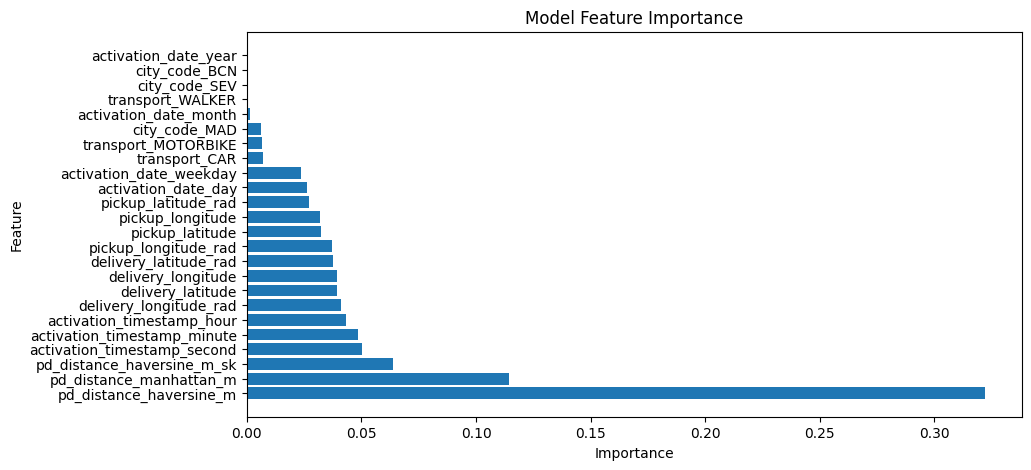

In [ ]:
model_decision_tree_cyclical.plot_feature_importance(X_test)

In [78]:
y_test_0 = y_test.loc[0]
y_test_0_pred = model_decision_tree_cyclical.predict(X_test.iloc[[0]]).item()
print(f"True delivery time: {y_test_0}")
print(f"Predicted delivery time: {y_test_0_pred}")
print(f"Diff: {y_test_0_pred - y_test_0}")

True delivery time: 319.677
Predicted delivery time: 334.434
Diff: 14.757000000000005


In [79]:
results_dataset = model_decision_tree_cyclical.test(data_test, y_test)
results_dataset.head(20)

,country_code,order_id,courier_id,creation_timestamp,activation_timestamp,transport,pickup_latitude,pickup_longitude,delivery_latitude,delivery_longitude,...,delivery_latitude_rad,delivery_longitude_rad,pd_distance_haversine_m,pd_distance_haversine_m_sk,pd_distance_manhattan_m,creation_date,city_code,target,prediction,residual
0,ES,100933187613,176241347,2024-10-14 23:24:53+00:00,2024-10-14 23:24:54+00:00,BICYCLE,38.35,-0.48,38.35,-0.49,...,0.67,-0.01,636.15,636.15,893.84,2024-10-14,ALC,319.68,334.43,14.76
1,ES,100933198445,10191824,2024-10-14 23:37:45+00:00,2024-10-14 23:37:46+00:00,MOTORBIKE,38.35,-0.48,38.34,-0.49,...,0.67,-0.01,774.11,774.11,1012.03,2024-10-14,ALC,811.65,326.05,-485.60
2,ES,100931749423,169099229,2024-10-14 12:57:37+00:00,2024-10-14 12:57:38+00:00,CAR,38.36,-0.49,38.34,-0.49,...,0.67,-0.01,2205.90,2205.90,2337.58,2024-10-14,ALC,614.70,470.89,-143.81
3,ES,100931867858,177428955,2024-10-14 13:44:05+00:00,2024-10-14 13:44:06+00:00,BICYCLE,38.35,-0.47,38.34,-0.50,...,0.67,-0.01,2628.16,2628.16,3677.11,2024-10-14,ALC,1111.15,1135.30,24.15
4,ES,100931917343,3548605,2024-10-14 14:03:19+00:00,2024-10-14 14:03:20+00:00,CAR,38.35,-0.49,38.35,-0.49,...,0.67,-0.01,681.33,681.33,941.43,2024-10-14,ALC,806.57,345.86,-460.71
5,ES,100931951627,173230053,2024-10-14 14:16:28+00:00,2024-10-14 14:16:29+00:00,MOTORBIKE,38.36,-0.50,38.37,-0.43,...,0.67,-0.01,6103.51,6103.51,6660.54,2024-10-14,ALC,1105.37,873.16,-232.21
6,ES,100932201108,141248791,2024-10-14 16:08:33+00:00,2024-10-14 16:08:35+00:00,MOTORBIKE,38.37,-0.51,38.38,-0.50,...,0.67,-0.01,819.69,819.69,1097.23,2024-10-14,ALC,290.56,503.36,212.80
7,ES,100932473558,39980765,2024-10-14 18:16:45+00:00,2024-10-14 18:16:45+00:00,CAR,38.35,-0.48,38.35,-0.52,...,0.67,-0.01,2808.36,2808.36,2975.41,2024-10-14,ALC,754.79,875.14,120.35
8,ES,100932857877,177428955,2024-10-14 20:36:33+00:00,2024-10-14 20:36:34+00:00,BICYCLE,38.35,-0.47,38.34,-0.48,...,0.67,-0.01,1575.89,1575.89,2230.19,2024-10-14,ALC,1476.80,524.36,-952.44
9,ES,100932926010,171303156,2024-10-14 21:00:04+00:00,2024-10-14 21:00:05+00:00,MOTORBIKE,38.37,-0.41,38.39,-0.41,...,0.67,-0.01,2062.63,2062.63,2099.82,2024-10-14,ALC,622.03,294.61,-327.42


In [80]:
model_decision_tree_cyclical_eval = model_decision_tree_cyclical.evaluate(X_test, y_test)
print(f"Decision Tree Model (Cyclical) Evaluation: MAE: {model_decision_tree_cyclical_eval[0]}, MSE: {model_decision_tree_cyclical_eval[1]}, R2: {model_decision_tree_cyclical_eval[2]}")

Decision Tree Model (Cyclical) Evaluation: MAE: 275.16036166392803, MSE: 269227.6514868668, R2: -0.700705087197542


#### Hyperparameters tuning

In [81]:
model_decision_tree_5 = RegressionTreeMethod(model_type = 'tree', encoding = 'dummy', min_samples_leaf=5)
model_decision_tree_5.fit(X_train, y_train)
model_decision_tree_5_eval = model_decision_tree_5.evaluate(X_test, y_test)
print(f"Decision Tree Model Evaluation: MAE: {model_decision_tree_5_eval[0]}, MSE: {model_decision_tree_5_eval[1]}, R2: {model_decision_tree_5_eval[2]}")

INFO:root:Train datasets shapes: X: (688815, 16), y: (688815,)
INFO:root:Train datasets columns: Index(['country_code', 'city_code', 'activation_timestamp', 'transport',
       'pickup_latitude', 'pickup_longitude', 'delivery_latitude',
       'delivery_longitude', 'time_zone', 'pickup_latitude_rad',
       'pickup_longitude_rad', 'delivery_latitude_rad',
       'delivery_longitude_rad', 'pd_distance_haversine_m',
       'pd_distance_haversine_m_sk', 'pd_distance_manhattan_m'],
      dtype='object')
INFO:root:Starting to encode variables
INFO:root:Encoded dataset shape: X: (688815, 24)
INFO:root:Finished to encode variables. Starting to fit the model
INFO:root:Finished training the model


Decision Tree Model Evaluation: MAE: 219.21955341245194, MSE: 148047.19497773796, R2: 0.06478916168739957


In [82]:
print(f"Model depth: {model_decision_tree_5.model.get_depth()}, Model number of leaves: {model_decision_tree_5.model.get_n_leaves()}, Model params:\n{model_decision_tree_5.model.get_params()}")

Model depth: 46, Model number of leaves: 110523, Model params:
{'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 5, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'random_state': None, 'splitter': 'best'}


In [83]:
model_decision_tree_10 = RegressionTreeMethod(model_type = 'tree', encoding = 'cyclical', max_depth=50, min_samples_leaf=10)
model_decision_tree_10.fit(X_train, y_train)
model_decision_tree_10_eval = model_decision_tree_10.evaluate(X_test, y_test)
print(f"Decision Tree Model Evaluation: MAE: {model_decision_tree_10_eval[0]}, MSE: {model_decision_tree_10_eval[1]}, R2: {model_decision_tree_10_eval[2]}")

INFO:root:Train datasets shapes: X: (688815, 16), y: (688815,)
INFO:root:Train datasets columns: Index(['country_code', 'city_code', 'activation_timestamp', 'transport',
       'pickup_latitude', 'pickup_longitude', 'delivery_latitude',
       'delivery_longitude', 'time_zone', 'pickup_latitude_rad',
       'pickup_longitude_rad', 'delivery_latitude_rad',
       'delivery_longitude_rad', 'pd_distance_haversine_m',
       'pd_distance_haversine_m_sk', 'pd_distance_manhattan_m'],
      dtype='object')
INFO:root:Starting to encode variables
INFO:root:Encoded dataset shape: X: (688815, 31)
INFO:root:Finished to encode variables. Starting to fit the model
INFO:root:Finished training the model


Decision Tree Model Evaluation: MAE: 205.08540587259088, MSE: 131396.628290107, R2: 0.16997042116793726


In [84]:
print(f"Model depth: {model_decision_tree_10.model.get_depth()}, Model number of leaves: {model_decision_tree_10.model.get_n_leaves()}, Model params:\n{model_decision_tree_10.model.get_params()}")

Model depth: 41, Model number of leaves: 53794, Model params:
{'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': 50, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 10, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'random_state': None, 'splitter': 'best'}


### Random Forest

In [85]:
start = datetime.datetime.now()
model_random_forest = RegressionTreeMethod(model_type = 'randomforest', encoding = 'dummy', n_estimators = 100)
model_random_forest.fit(X_train, y_train)
end = datetime.datetime.now()
model_random_forest_time = end - start
model_random_forest_eval = model_random_forest.evaluate(X_test, y_test)
print(f"Random Forest Model Evaluation: MAE: {model_random_forest_eval[0]}, MSE: {model_random_forest_eval[1]}, R2: {model_random_forest_eval[2]}")

INFO:root:Train datasets shapes: X: (688815, 16), y: (688815,)
INFO:root:Train datasets columns: Index(['country_code', 'city_code', 'activation_timestamp', 'transport',
       'pickup_latitude', 'pickup_longitude', 'delivery_latitude',
       'delivery_longitude', 'time_zone', 'pickup_latitude_rad',
       'pickup_longitude_rad', 'delivery_latitude_rad',
       'delivery_longitude_rad', 'pd_distance_haversine_m',
       'pd_distance_haversine_m_sk', 'pd_distance_manhattan_m'],
      dtype='object')
INFO:root:Starting to encode variables
INFO:root:Encoded dataset shape: X: (688815, 24)
INFO:root:Finished to encode variables. Starting to fit the model
INFO:root:Finished training the model


Random Forest Model Evaluation: MAE: 176.58029950024292, MSE: 112244.7493151677, R2: 0.29095241474172806


In [86]:
start = datetime.datetime.now()
model_random_forest_cyclical = RegressionTreeMethod(model_type = 'randomforest', encoding = 'cyclical', n_estimators = 100)
model_random_forest_cyclical.fit(X_train, y_train)
end = datetime.datetime.now()
model_random_forest_cyclical_time = end - start
print(f"Time elapsed: {model_random_forest_cyclical_time}")

INFO:root:Train datasets shapes: X: (688815, 16), y: (688815,)
INFO:root:Train datasets columns: Index(['country_code', 'city_code', 'activation_timestamp', 'transport',
       'pickup_latitude', 'pickup_longitude', 'delivery_latitude',
       'delivery_longitude', 'time_zone', 'pickup_latitude_rad',
       'pickup_longitude_rad', 'delivery_latitude_rad',
       'delivery_longitude_rad', 'pd_distance_haversine_m',
       'pd_distance_haversine_m_sk', 'pd_distance_manhattan_m'],
      dtype='object')
INFO:root:Starting to encode variables
INFO:root:Encoded dataset shape: X: (688815, 31)
INFO:root:Finished to encode variables. Starting to fit the model
INFO:root:Finished training the model


Time elapsed: 0:27:44.039555


Index(['pickup_latitude', 'pickup_longitude', 'delivery_latitude',
       'delivery_longitude', 'pickup_latitude_rad', 'pickup_longitude_rad',
       'delivery_latitude_rad', 'delivery_longitude_rad',
       'pd_distance_haversine_m', 'pd_distance_haversine_m_sk',
       'pd_distance_manhattan_m', 'activation_date_year_sin',
       'activation_date_year_cos', 'activation_date_month_sin',
       'activation_date_month_cos', 'activation_date_day_sin',
       'activation_date_day_cos', 'activation_date_weekday_sin',
       'activation_date_weekday_cos', 'activation_timestamp_hour_sin',
       'activation_timestamp_hour_cos', 'activation_timestamp_minute_sin',
       'activation_timestamp_minute_cos', 'activation_timestamp_second_sin',
       'activation_timestamp_second_cos', 'city_code_BCN', 'city_code_MAD',
       'city_code_SEV', 'transport_CAR', 'transport_MOTORBIKE',
       'transport_WALKER'],
      dtype='object')
[2.85781921e-02 3.06654781e-02 3.71601660e-02 3.62457064e-02
 2.7287

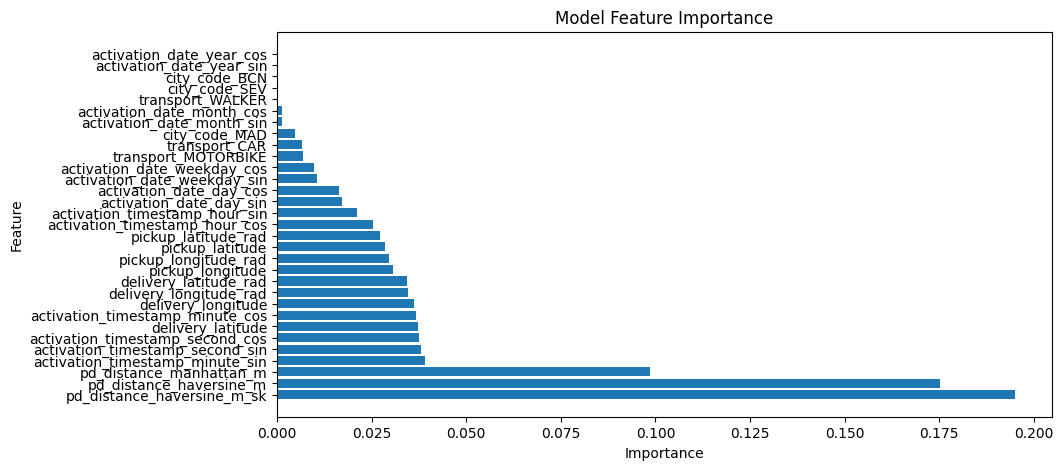

In [88]:
model_random_forest_cyclical.plot_feature_importance(X_test)

In [87]:
y_test_0 = y_test.loc[0]
y_test_0_pred = model_random_forest_cyclical.predict(X_test.iloc[[0]]).item()
print(f"True delivery time: {y_test_0}")
print(f"Predicted delivery time: {y_test_0_pred}")
print(f"Diff: {y_test_0_pred - y_test_0}")

True delivery time: 319.677
Predicted delivery time: 376.32492999999994
Diff: 56.64792999999992


In [89]:
results_dataset = model_random_forest_cyclical.test(data_test, y_test)
results_dataset.head(20)

,country_code,order_id,courier_id,creation_timestamp,activation_timestamp,transport,pickup_latitude,pickup_longitude,delivery_latitude,delivery_longitude,...,delivery_latitude_rad,delivery_longitude_rad,pd_distance_haversine_m,pd_distance_haversine_m_sk,pd_distance_manhattan_m,creation_date,city_code,target,prediction,residual
0,ES,100933187613,176241347,2024-10-14 23:24:53+00:00,2024-10-14 23:24:54+00:00,BICYCLE,38.35,-0.48,38.35,-0.49,...,0.67,-0.01,636.15,636.15,893.84,2024-10-14,ALC,319.68,376.32,56.65
1,ES,100933198445,10191824,2024-10-14 23:37:45+00:00,2024-10-14 23:37:46+00:00,MOTORBIKE,38.35,-0.48,38.34,-0.49,...,0.67,-0.01,774.11,774.11,1012.03,2024-10-14,ALC,811.65,454.90,-356.75
2,ES,100931749423,169099229,2024-10-14 12:57:37+00:00,2024-10-14 12:57:38+00:00,CAR,38.36,-0.49,38.34,-0.49,...,0.67,-0.01,2205.90,2205.90,2337.58,2024-10-14,ALC,614.70,832.49,217.79
3,ES,100931867858,177428955,2024-10-14 13:44:05+00:00,2024-10-14 13:44:06+00:00,BICYCLE,38.35,-0.47,38.34,-0.50,...,0.67,-0.01,2628.16,2628.16,3677.11,2024-10-14,ALC,1111.15,912.37,-198.79
4,ES,100931917343,3548605,2024-10-14 14:03:19+00:00,2024-10-14 14:03:20+00:00,CAR,38.35,-0.49,38.35,-0.49,...,0.67,-0.01,681.33,681.33,941.43,2024-10-14,ALC,806.57,590.71,-215.85
5,ES,100931951627,173230053,2024-10-14 14:16:28+00:00,2024-10-14 14:16:29+00:00,MOTORBIKE,38.36,-0.50,38.37,-0.43,...,0.67,-0.01,6103.51,6103.51,6660.54,2024-10-14,ALC,1105.37,1210.75,105.38
6,ES,100932201108,141248791,2024-10-14 16:08:33+00:00,2024-10-14 16:08:35+00:00,MOTORBIKE,38.37,-0.51,38.38,-0.50,...,0.67,-0.01,819.69,819.69,1097.23,2024-10-14,ALC,290.56,412.49,121.93
7,ES,100932473558,39980765,2024-10-14 18:16:45+00:00,2024-10-14 18:16:45+00:00,CAR,38.35,-0.48,38.35,-0.52,...,0.67,-0.01,2808.36,2808.36,2975.41,2024-10-14,ALC,754.79,964.52,209.73
8,ES,100932857877,177428955,2024-10-14 20:36:33+00:00,2024-10-14 20:36:34+00:00,BICYCLE,38.35,-0.47,38.34,-0.48,...,0.67,-0.01,1575.89,1575.89,2230.19,2024-10-14,ALC,1476.80,743.20,-733.60
9,ES,100932926010,171303156,2024-10-14 21:00:04+00:00,2024-10-14 21:00:05+00:00,MOTORBIKE,38.37,-0.41,38.39,-0.41,...,0.67,-0.01,2062.63,2062.63,2099.82,2024-10-14,ALC,622.03,595.21,-26.82


In [90]:
model_random_forest_cyclical_eval = model_random_forest_cyclical.evaluate(X_test, y_test)
print(f"Random Forest Model (Cyclical) Evaluation: MAE: {model_random_forest_cyclical_eval[0]}, MSE: {model_random_forest_cyclical_eval[1]}, R2: {model_random_forest_cyclical_eval[2]}")

Random Forest Model (Cyclical) Evaluation: MAE: 185.89900521994107, MSE: 116492.31115368176, R2: 0.26412066106764676


### Gradient Boosting

In [91]:
start = datetime.datetime.now()
model_gradient_boosting = RegressionTreeMethod(model_type = 'gradientboosting', encoding = 'dummy', n_estimators = 100)
model_gradient_boosting.fit(X_train, y_train)
end = datetime.datetime.now()
model_gradient_boosting_time = end - start
model_gradient_boosting_eval = model_gradient_boosting.evaluate(X_test, y_test)
print(f"Gradient Boosting Model Evaluation: MAE: {model_gradient_boosting_eval[0]}, MSE: {model_gradient_boosting_eval[1]}, R2: {model_gradient_boosting_eval[2]}")

INFO:root:Train datasets shapes: X: (688815, 16), y: (688815,)
INFO:root:Train datasets columns: Index(['country_code', 'city_code', 'activation_timestamp', 'transport',
       'pickup_latitude', 'pickup_longitude', 'delivery_latitude',
       'delivery_longitude', 'time_zone', 'pickup_latitude_rad',
       'pickup_longitude_rad', 'delivery_latitude_rad',
       'delivery_longitude_rad', 'pd_distance_haversine_m',
       'pd_distance_haversine_m_sk', 'pd_distance_manhattan_m'],
      dtype='object')
INFO:root:Starting to encode variables
INFO:root:Encoded dataset shape: X: (688815, 24)
INFO:root:Finished to encode variables. Starting to fit the model
INFO:root:Finished training the model


Gradient Boosting Model Evaluation: MAE: 172.24534159595896, MSE: 108798.90120619696, R2: 0.31271976061527207


In [92]:
start = datetime.datetime.now()
model_gradient_boosting_cyclical = RegressionTreeMethod(model_type = 'gradientboosting', encoding = 'cyclical', n_estimators = 100)
model_gradient_boosting_cyclical.fit(X_train, y_train)
end = datetime.datetime.now()
model_gradient_boosting_cyclical_time = end - start
print(f"Time elapsed: {model_gradient_boosting_cyclical_time}")

INFO:root:Train datasets shapes: X: (688815, 16), y: (688815,)
INFO:root:Train datasets columns: Index(['country_code', 'city_code', 'activation_timestamp', 'transport',
       'pickup_latitude', 'pickup_longitude', 'delivery_latitude',
       'delivery_longitude', 'time_zone', 'pickup_latitude_rad',
       'pickup_longitude_rad', 'delivery_latitude_rad',
       'delivery_longitude_rad', 'pd_distance_haversine_m',
       'pd_distance_haversine_m_sk', 'pd_distance_manhattan_m'],
      dtype='object')
INFO:root:Starting to encode variables
INFO:root:Encoded dataset shape: X: (688815, 31)
INFO:root:Finished to encode variables. Starting to fit the model
INFO:root:Finished training the model


Time elapsed: 0:06:05.044001


Index(['pickup_latitude', 'pickup_longitude', 'delivery_latitude',
       'delivery_longitude', 'pickup_latitude_rad', 'pickup_longitude_rad',
       'delivery_latitude_rad', 'delivery_longitude_rad',
       'pd_distance_haversine_m', 'pd_distance_haversine_m_sk',
       'pd_distance_manhattan_m', 'activation_date_year_sin',
       'activation_date_year_cos', 'activation_date_month_sin',
       'activation_date_month_cos', 'activation_date_day_sin',
       'activation_date_day_cos', 'activation_date_weekday_sin',
       'activation_date_weekday_cos', 'activation_timestamp_hour_sin',
       'activation_timestamp_hour_cos', 'activation_timestamp_minute_sin',
       'activation_timestamp_minute_cos', 'activation_timestamp_second_sin',
       'activation_timestamp_second_cos', 'city_code_BCN', 'city_code_MAD',
       'city_code_SEV', 'transport_CAR', 'transport_MOTORBIKE',
       'transport_WALKER'],
      dtype='object')
[1.17022740e-02 1.19542542e-02 6.62617987e-03 8.08790229e-03
 5.6824

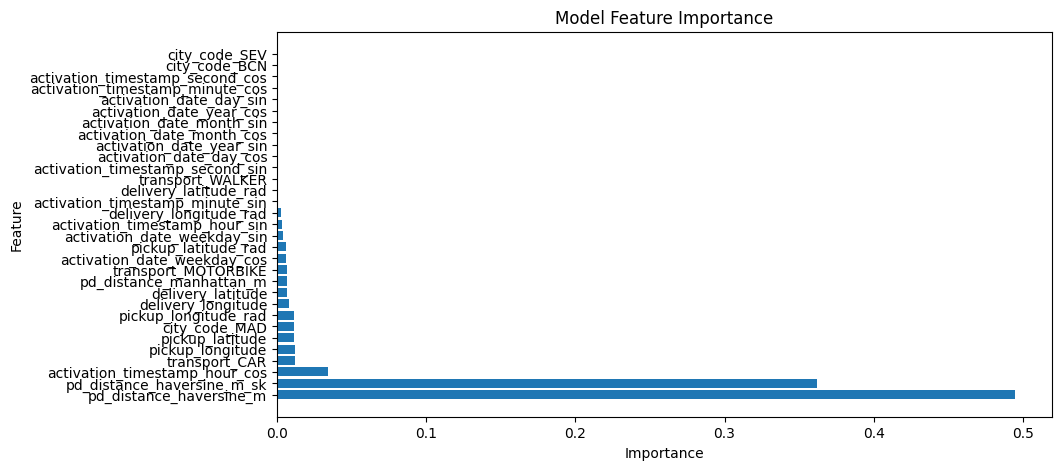

In [93]:
model_gradient_boosting_cyclical.plot_feature_importance(X_test)

In [94]:
y_test_0 = y_test.loc[0]
y_test_0_pred = model_gradient_boosting_cyclical.predict(X_test.iloc[[0]]).item()
print(f"True delivery time: {y_test_0}")
print(f"Predicted delivery time: {y_test_0_pred}")
print(f"Diff: {y_test_0_pred - y_test_0}")

True delivery time: 319.677
Predicted delivery time: 469.8233523712579
Diff: 150.14635237125788


In [95]:
results_dataset = model_gradient_boosting_cyclical.test(data_test, y_test)
results_dataset.head(20)

,country_code,order_id,courier_id,creation_timestamp,activation_timestamp,transport,pickup_latitude,pickup_longitude,delivery_latitude,delivery_longitude,...,delivery_latitude_rad,delivery_longitude_rad,pd_distance_haversine_m,pd_distance_haversine_m_sk,pd_distance_manhattan_m,creation_date,city_code,target,prediction,residual
0,ES,100933187613,176241347,2024-10-14 23:24:53+00:00,2024-10-14 23:24:54+00:00,BICYCLE,38.35,-0.48,38.35,-0.49,...,0.67,-0.01,636.15,636.15,893.84,2024-10-14,ALC,319.68,469.82,150.15
1,ES,100933198445,10191824,2024-10-14 23:37:45+00:00,2024-10-14 23:37:46+00:00,MOTORBIKE,38.35,-0.48,38.34,-0.49,...,0.67,-0.01,774.11,774.11,1012.03,2024-10-14,ALC,811.65,460.55,-351.09
2,ES,100931749423,169099229,2024-10-14 12:57:37+00:00,2024-10-14 12:57:38+00:00,CAR,38.36,-0.49,38.34,-0.49,...,0.67,-0.01,2205.90,2205.90,2337.58,2024-10-14,ALC,614.70,782.31,167.61
3,ES,100931867858,177428955,2024-10-14 13:44:05+00:00,2024-10-14 13:44:06+00:00,BICYCLE,38.35,-0.47,38.34,-0.50,...,0.67,-0.01,2628.16,2628.16,3677.11,2024-10-14,ALC,1111.15,995.82,-115.33
4,ES,100931917343,3548605,2024-10-14 14:03:19+00:00,2024-10-14 14:03:20+00:00,CAR,38.35,-0.49,38.35,-0.49,...,0.67,-0.01,681.33,681.33,941.43,2024-10-14,ALC,806.57,486.77,-319.79
5,ES,100931951627,173230053,2024-10-14 14:16:28+00:00,2024-10-14 14:16:29+00:00,MOTORBIKE,38.36,-0.50,38.37,-0.43,...,0.67,-0.01,6103.51,6103.51,6660.54,2024-10-14,ALC,1105.37,1255.33,149.96
6,ES,100932201108,141248791,2024-10-14 16:08:33+00:00,2024-10-14 16:08:35+00:00,MOTORBIKE,38.37,-0.51,38.38,-0.50,...,0.67,-0.01,819.69,819.69,1097.23,2024-10-14,ALC,290.56,519.03,228.47
7,ES,100932473558,39980765,2024-10-14 18:16:45+00:00,2024-10-14 18:16:45+00:00,CAR,38.35,-0.48,38.35,-0.52,...,0.67,-0.01,2808.36,2808.36,2975.41,2024-10-14,ALC,754.79,875.70,120.90
8,ES,100932857877,177428955,2024-10-14 20:36:33+00:00,2024-10-14 20:36:34+00:00,BICYCLE,38.35,-0.47,38.34,-0.48,...,0.67,-0.01,1575.89,1575.89,2230.19,2024-10-14,ALC,1476.80,695.00,-781.80
9,ES,100932926010,171303156,2024-10-14 21:00:04+00:00,2024-10-14 21:00:05+00:00,MOTORBIKE,38.37,-0.41,38.39,-0.41,...,0.67,-0.01,2062.63,2062.63,2099.82,2024-10-14,ALC,622.03,611.30,-10.73


In [96]:
model_gradient_boosting_cyclical_eval = model_gradient_boosting_cyclical.evaluate(X_test, y_test)
print(f"Gradient Boosting Model (Cyclical) Evaluation: MAE: {model_gradient_boosting_cyclical_eval[0]}, MSE: {model_gradient_boosting_cyclical_eval[1]}, R2: {model_gradient_boosting_cyclical_eval[2]}")

Gradient Boosting Model (Cyclical) Evaluation: MAE: 171.9185225086474, MSE: 108486.44361811946, R2: 0.3146935482505394


### Hist Gradient Boosting

In [97]:
start = datetime.datetime.now()
model_hist_gradient_boosting = RegressionTreeMethod(model_type = 'histgradientboosting', encoding = 'dummy', max_iter = 100)
model_hist_gradient_boosting.fit(X_train, y_train)
end = datetime.datetime.now()
model_hist_gradient_boosting_time = end - start
model_hist_gradient_boosting_eval = model_hist_gradient_boosting.evaluate(X_test, y_test)
print(f"Histogram-based Gradient Boosting Model Evaluation: MAE: {model_hist_gradient_boosting_eval[0]}, MSE: {model_hist_gradient_boosting_eval[1]}, R2: {model_hist_gradient_boosting_eval[2]}")

INFO:root:Train datasets shapes: X: (688815, 16), y: (688815,)
INFO:root:Train datasets columns: Index(['country_code', 'city_code', 'activation_timestamp', 'transport',
       'pickup_latitude', 'pickup_longitude', 'delivery_latitude',
       'delivery_longitude', 'time_zone', 'pickup_latitude_rad',
       'pickup_longitude_rad', 'delivery_latitude_rad',
       'delivery_longitude_rad', 'pd_distance_haversine_m',
       'pd_distance_haversine_m_sk', 'pd_distance_manhattan_m'],
      dtype='object')
INFO:root:Starting to encode variables
INFO:root:Encoded dataset shape: X: (688815, 24)
INFO:root:Finished to encode variables. Starting to fit the model
INFO:root:Finished training the model


Histogram-based Gradient Boosting Model Evaluation: MAE: 168.7595470631822, MSE: 106603.81370359377, R2: 0.326586079553552


In [98]:
start = datetime.datetime.now()
model_hist_gradient_boosting_cyclical = RegressionTreeMethod(model_type = 'histgradientboosting', encoding = 'cyclical', max_iter = 100)
model_hist_gradient_boosting_cyclical.fit(X_train, y_train)
end = datetime.datetime.now()
model_hist_gradient_boosting_cyclical_time = end - start
print(f"Time elapsed: {model_hist_gradient_boosting_cyclical_time}")

INFO:root:Train datasets shapes: X: (688815, 16), y: (688815,)
INFO:root:Train datasets columns: Index(['country_code', 'city_code', 'activation_timestamp', 'transport',
       'pickup_latitude', 'pickup_longitude', 'delivery_latitude',
       'delivery_longitude', 'time_zone', 'pickup_latitude_rad',
       'pickup_longitude_rad', 'delivery_latitude_rad',
       'delivery_longitude_rad', 'pd_distance_haversine_m',
       'pd_distance_haversine_m_sk', 'pd_distance_manhattan_m'],
      dtype='object')
INFO:root:Starting to encode variables
INFO:root:Encoded dataset shape: X: (688815, 31)
INFO:root:Finished to encode variables. Starting to fit the model
INFO:root:Finished training the model


Time elapsed: 0:00:06.248017


In [99]:
try:
    model_hist_gradient_boosting_cyclical.plot_feature_importance(X_test)
except AttributeError as e:
    print(e)

The model type: histgradientboosting does not support feature importance plotting.


In [100]:
y_test_0 = y_test.loc[0]
y_test_0_pred = model_hist_gradient_boosting_cyclical.predict(X_test.iloc[[0]]).item()
print(f"True delivery time: {y_test_0}")
print(f"Predicted delivery time: {y_test_0_pred}")
print(f"Diff: {y_test_0_pred - y_test_0}")

True delivery time: 319.677
Predicted delivery time: 462.8308597606395
Diff: 143.15385976063948


In [101]:
results_dataset = model_hist_gradient_boosting_cyclical.test(data_test, y_test)
results_dataset.head(20)

,country_code,order_id,courier_id,creation_timestamp,activation_timestamp,transport,pickup_latitude,pickup_longitude,delivery_latitude,delivery_longitude,...,delivery_latitude_rad,delivery_longitude_rad,pd_distance_haversine_m,pd_distance_haversine_m_sk,pd_distance_manhattan_m,creation_date,city_code,target,prediction,residual
0,ES,100933187613,176241347,2024-10-14 23:24:53+00:00,2024-10-14 23:24:54+00:00,BICYCLE,38.35,-0.48,38.35,-0.49,...,0.67,-0.01,636.15,636.15,893.84,2024-10-14,ALC,319.68,462.83,143.15
1,ES,100933198445,10191824,2024-10-14 23:37:45+00:00,2024-10-14 23:37:46+00:00,MOTORBIKE,38.35,-0.48,38.34,-0.49,...,0.67,-0.01,774.11,774.11,1012.03,2024-10-14,ALC,811.65,439.33,-372.32
2,ES,100931749423,169099229,2024-10-14 12:57:37+00:00,2024-10-14 12:57:38+00:00,CAR,38.36,-0.49,38.34,-0.49,...,0.67,-0.01,2205.90,2205.90,2337.58,2024-10-14,ALC,614.70,683.64,68.94
3,ES,100931867858,177428955,2024-10-14 13:44:05+00:00,2024-10-14 13:44:06+00:00,BICYCLE,38.35,-0.47,38.34,-0.50,...,0.67,-0.01,2628.16,2628.16,3677.11,2024-10-14,ALC,1111.15,985.22,-125.94
4,ES,100931917343,3548605,2024-10-14 14:03:19+00:00,2024-10-14 14:03:20+00:00,CAR,38.35,-0.49,38.35,-0.49,...,0.67,-0.01,681.33,681.33,941.43,2024-10-14,ALC,806.57,469.13,-337.43
5,ES,100931951627,173230053,2024-10-14 14:16:28+00:00,2024-10-14 14:16:29+00:00,MOTORBIKE,38.36,-0.50,38.37,-0.43,...,0.67,-0.01,6103.51,6103.51,6660.54,2024-10-14,ALC,1105.37,1266.87,161.51
6,ES,100932201108,141248791,2024-10-14 16:08:33+00:00,2024-10-14 16:08:35+00:00,MOTORBIKE,38.37,-0.51,38.38,-0.50,...,0.67,-0.01,819.69,819.69,1097.23,2024-10-14,ALC,290.56,501.95,211.39
7,ES,100932473558,39980765,2024-10-14 18:16:45+00:00,2024-10-14 18:16:45+00:00,CAR,38.35,-0.48,38.35,-0.52,...,0.67,-0.01,2808.36,2808.36,2975.41,2024-10-14,ALC,754.79,814.17,59.38
8,ES,100932857877,177428955,2024-10-14 20:36:33+00:00,2024-10-14 20:36:34+00:00,BICYCLE,38.35,-0.47,38.34,-0.48,...,0.67,-0.01,1575.89,1575.89,2230.19,2024-10-14,ALC,1476.80,727.98,-748.82
9,ES,100932926010,171303156,2024-10-14 21:00:04+00:00,2024-10-14 21:00:05+00:00,MOTORBIKE,38.37,-0.41,38.39,-0.41,...,0.67,-0.01,2062.63,2062.63,2099.82,2024-10-14,ALC,622.03,573.87,-48.16


In [102]:
model_hist_gradient_boosting_cyclical_eval = model_hist_gradient_boosting_cyclical.evaluate(X_test, y_test)
print(f"Histogram-based Gradient Boosting Model (Cyclical) Evaluation: MAE: {model_hist_gradient_boosting_cyclical_eval[0]}, MSE: {model_hist_gradient_boosting_cyclical_eval[1]}, R2: {model_hist_gradient_boosting_cyclical_eval[2]}")

Histogram-based Gradient Boosting Model (Cyclical) Evaluation: MAE: 167.6755051844075, MSE: 106719.3126712288, R2: 0.32585647514353633


### XGBoost

In [103]:
start = datetime.datetime.now()
model_xgboost_cyclical = RegressionTreeMethod(model_type = 'xgboost', encoding = 'cyclical', max_iter = 100)
model_xgboost_cyclical.fit(X_train, y_train)
end = datetime.datetime.now()
model_xgboost_cyclical_time = end - start
print(f"Time elapsed: {model_xgboost_cyclical_time}")

INFO:root:Train datasets shapes: X: (688815, 16), y: (688815,)
INFO:root:Train datasets columns: Index(['country_code', 'city_code', 'activation_timestamp', 'transport',
       'pickup_latitude', 'pickup_longitude', 'delivery_latitude',
       'delivery_longitude', 'time_zone', 'pickup_latitude_rad',
       'pickup_longitude_rad', 'delivery_latitude_rad',
       'delivery_longitude_rad', 'pd_distance_haversine_m',
       'pd_distance_haversine_m_sk', 'pd_distance_manhattan_m'],
      dtype='object')
INFO:root:Starting to encode variables
INFO:root:Encoded dataset shape: X: (688815, 31)
INFO:root:Finished to encode variables. Starting to fit the model
/Users/angela.carraroglovoappcom/Documents/GitHub/pickup-to-delivery-overall/venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [18:12:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "max_iter" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
INFO:root:Finished training th

Time elapsed: 0:00:03.270313


Index(['pickup_latitude', 'pickup_longitude', 'delivery_latitude',
       'delivery_longitude', 'pickup_latitude_rad', 'pickup_longitude_rad',
       'delivery_latitude_rad', 'delivery_longitude_rad',
       'pd_distance_haversine_m', 'pd_distance_haversine_m_sk',
       'pd_distance_manhattan_m', 'activation_date_year_sin',
       'activation_date_year_cos', 'activation_date_month_sin',
       'activation_date_month_cos', 'activation_date_day_sin',
       'activation_date_day_cos', 'activation_date_weekday_sin',
       'activation_date_weekday_cos', 'activation_timestamp_hour_sin',
       'activation_timestamp_hour_cos', 'activation_timestamp_minute_sin',
       'activation_timestamp_minute_cos', 'activation_timestamp_second_sin',
       'activation_timestamp_second_cos', 'city_code_BCN', 'city_code_MAD',
       'city_code_SEV', 'transport_CAR', 'transport_MOTORBIKE',
       'transport_WALKER'],
      dtype='object')
[0.01617941 0.01683838 0.01865324 0.01445958 0.01092034 0.
 0.010297

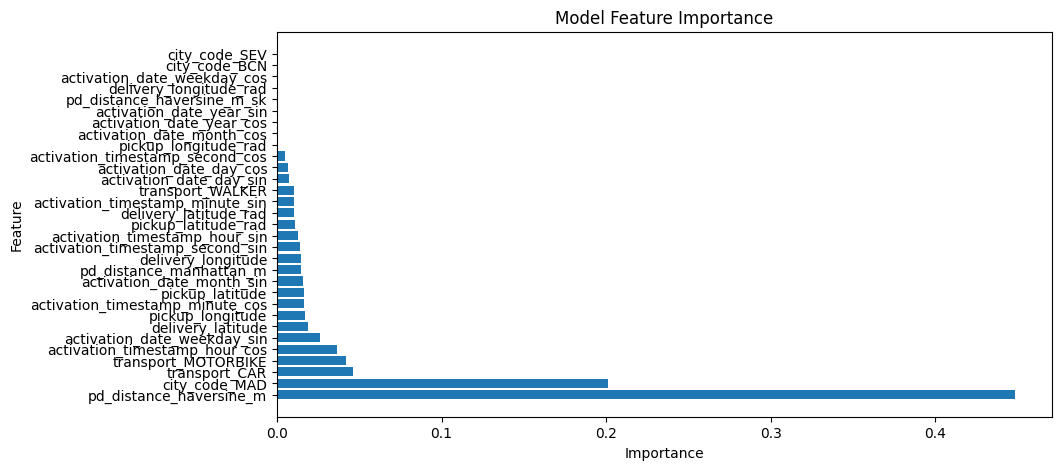

In [104]:
model_xgboost_cyclical.plot_feature_importance(X_test)

In [105]:
y_test_0 = y_test.loc[0]
y_test_0_pred = model_xgboost_cyclical.predict(X_test.iloc[[0]]).item()
print(f"True delivery time: {y_test_0}")
print(f"Predicted delivery time: {y_test_0_pred}")
print(f"Diff: {y_test_0_pred - y_test_0}")

True delivery time: 319.677
Predicted delivery time: 481.7569885253906
Diff: 162.0799885253906


In [106]:
results_dataset = model_xgboost_cyclical.test(data_test, y_test)
results_dataset.head(20)

,country_code,order_id,courier_id,creation_timestamp,activation_timestamp,transport,pickup_latitude,pickup_longitude,delivery_latitude,delivery_longitude,...,delivery_latitude_rad,delivery_longitude_rad,pd_distance_haversine_m,pd_distance_haversine_m_sk,pd_distance_manhattan_m,creation_date,city_code,target,prediction,residual
0,ES,100933187613,176241347,2024-10-14 23:24:53+00:00,2024-10-14 23:24:54+00:00,BICYCLE,38.35,-0.48,38.35,-0.49,...,0.67,-0.01,636.15,636.15,893.84,2024-10-14,ALC,319.68,481.76,162.08
1,ES,100933198445,10191824,2024-10-14 23:37:45+00:00,2024-10-14 23:37:46+00:00,MOTORBIKE,38.35,-0.48,38.34,-0.49,...,0.67,-0.01,774.11,774.11,1012.03,2024-10-14,ALC,811.65,375.02,-436.63
2,ES,100931749423,169099229,2024-10-14 12:57:37+00:00,2024-10-14 12:57:38+00:00,CAR,38.36,-0.49,38.34,-0.49,...,0.67,-0.01,2205.90,2205.90,2337.58,2024-10-14,ALC,614.70,879.18,264.48
3,ES,100931867858,177428955,2024-10-14 13:44:05+00:00,2024-10-14 13:44:06+00:00,BICYCLE,38.35,-0.47,38.34,-0.50,...,0.67,-0.01,2628.16,2628.16,3677.11,2024-10-14,ALC,1111.15,974.64,-136.52
4,ES,100931917343,3548605,2024-10-14 14:03:19+00:00,2024-10-14 14:03:20+00:00,CAR,38.35,-0.49,38.35,-0.49,...,0.67,-0.01,681.33,681.33,941.43,2024-10-14,ALC,806.57,516.11,-290.46
5,ES,100931951627,173230053,2024-10-14 14:16:28+00:00,2024-10-14 14:16:29+00:00,MOTORBIKE,38.36,-0.50,38.37,-0.43,...,0.67,-0.01,6103.51,6103.51,6660.54,2024-10-14,ALC,1105.37,1403.46,298.09
6,ES,100932201108,141248791,2024-10-14 16:08:33+00:00,2024-10-14 16:08:35+00:00,MOTORBIKE,38.37,-0.51,38.38,-0.50,...,0.67,-0.01,819.69,819.69,1097.23,2024-10-14,ALC,290.56,540.50,249.94
7,ES,100932473558,39980765,2024-10-14 18:16:45+00:00,2024-10-14 18:16:45+00:00,CAR,38.35,-0.48,38.35,-0.52,...,0.67,-0.01,2808.36,2808.36,2975.41,2024-10-14,ALC,754.79,948.02,193.23
8,ES,100932857877,177428955,2024-10-14 20:36:33+00:00,2024-10-14 20:36:34+00:00,BICYCLE,38.35,-0.47,38.34,-0.48,...,0.67,-0.01,1575.89,1575.89,2230.19,2024-10-14,ALC,1476.80,764.38,-712.42
9,ES,100932926010,171303156,2024-10-14 21:00:04+00:00,2024-10-14 21:00:05+00:00,MOTORBIKE,38.37,-0.41,38.39,-0.41,...,0.67,-0.01,2062.63,2062.63,2099.82,2024-10-14,ALC,622.03,547.23,-74.80


In [107]:
model_xgboost_cyclical_eval = model_xgboost_cyclical.evaluate(X_test, y_test)
print(f"XGBoost Model (Cyclical) Evaluation: MAE: {model_xgboost_cyclical_eval[0]}, MSE: {model_xgboost_cyclical_eval[1]}, R2: {model_xgboost_cyclical_eval[2]}")

XGBoost Model (Cyclical) Evaluation: MAE: 169.29106174183354, MSE: 107581.72230453278, R2: 0.32040865266873464


### LightGBM

In [108]:
start = datetime.datetime.now()
model_lightgbm_cyclical = RegressionTreeMethod(model_type = 'lightgbm', encoding = 'cyclical', max_iter = 100)
model_lightgbm_cyclical.fit(X_train, y_train)
end = datetime.datetime.now()
model_lightgbm_cyclical_time = end - start
print(f"Time elapsed: {model_lightgbm_cyclical_time}")

INFO:root:Train datasets shapes: X: (688815, 16), y: (688815,)
INFO:root:Train datasets columns: Index(['country_code', 'city_code', 'activation_timestamp', 'transport',
       'pickup_latitude', 'pickup_longitude', 'delivery_latitude',
       'delivery_longitude', 'time_zone', 'pickup_latitude_rad',
       'pickup_longitude_rad', 'delivery_latitude_rad',
       'delivery_longitude_rad', 'pd_distance_haversine_m',
       'pd_distance_haversine_m_sk', 'pd_distance_manhattan_m'],
      dtype='object')
INFO:root:Starting to encode variables
INFO:root:Encoded dataset shape: X: (688815, 31)
INFO:root:Finished to encode variables. Starting to fit the model


[LightGBM] [Warning] num_iterations is set=100, max_iter=100 will be ignored. Current value: num_iterations=100
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012408 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3097
[LightGBM] [Info] Number of data points in the train set: 688815, number of used features: 29
[LightGBM] [Info] Start training from score 634.533801


INFO:root:Finished training the model


Time elapsed: 0:00:03.010787


Index(['pickup_latitude', 'pickup_longitude', 'delivery_latitude',
       'delivery_longitude', 'pickup_latitude_rad', 'pickup_longitude_rad',
       'delivery_latitude_rad', 'delivery_longitude_rad',
       'pd_distance_haversine_m', 'pd_distance_haversine_m_sk',
       'pd_distance_manhattan_m', 'activation_date_year_sin',
       'activation_date_year_cos', 'activation_date_month_sin',
       'activation_date_month_cos', 'activation_date_day_sin',
       'activation_date_day_cos', 'activation_date_weekday_sin',
       'activation_date_weekday_cos', 'activation_timestamp_hour_sin',
       'activation_timestamp_hour_cos', 'activation_timestamp_minute_sin',
       'activation_timestamp_minute_cos', 'activation_timestamp_second_sin',
       'activation_timestamp_second_cos', 'city_code_BCN', 'city_code_MAD',
       'city_code_SEV', 'transport_CAR', 'transport_MOTORBIKE',
       'transport_WALKER'],
      dtype='object')
[492 518 298 341   0   0   0   0 356   0 131   0   0   0   0   9  16

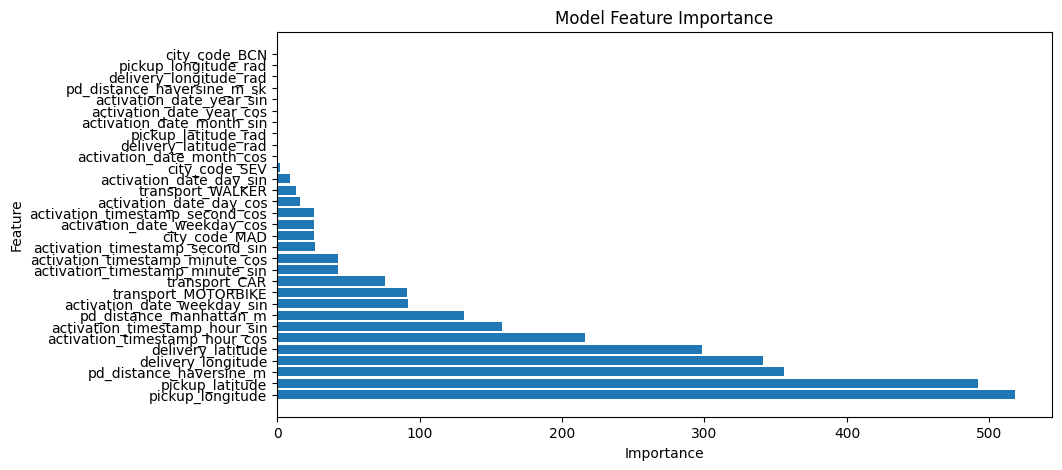

In [109]:
model_lightgbm_cyclical.plot_feature_importance(X_test)

In [110]:
y_test_0 = y_test.loc[0]
y_test_0_pred = model_lightgbm_cyclical.predict(X_test.iloc[[0]]).item()
print(f"True delivery time: {y_test_0}")
print(f"Predicted delivery time: {y_test_0_pred}")
print(f"Diff: {y_test_0_pred - y_test_0}")

True delivery time: 319.677
Predicted delivery time: 466.3456109181837
Diff: 146.66861091818367


In [111]:
results_dataset = model_lightgbm_cyclical.test(data_test, y_test)
results_dataset.head(20)

,country_code,order_id,courier_id,creation_timestamp,activation_timestamp,transport,pickup_latitude,pickup_longitude,delivery_latitude,delivery_longitude,...,delivery_latitude_rad,delivery_longitude_rad,pd_distance_haversine_m,pd_distance_haversine_m_sk,pd_distance_manhattan_m,creation_date,city_code,target,prediction,residual
0,ES,100933187613,176241347,2024-10-14 23:24:53+00:00,2024-10-14 23:24:54+00:00,BICYCLE,38.35,-0.48,38.35,-0.49,...,0.67,-0.01,636.15,636.15,893.84,2024-10-14,ALC,319.68,466.35,146.67
1,ES,100933198445,10191824,2024-10-14 23:37:45+00:00,2024-10-14 23:37:46+00:00,MOTORBIKE,38.35,-0.48,38.34,-0.49,...,0.67,-0.01,774.11,774.11,1012.03,2024-10-14,ALC,811.65,436.27,-375.38
2,ES,100931749423,169099229,2024-10-14 12:57:37+00:00,2024-10-14 12:57:38+00:00,CAR,38.36,-0.49,38.34,-0.49,...,0.67,-0.01,2205.90,2205.90,2337.58,2024-10-14,ALC,614.70,698.55,83.85
3,ES,100931867858,177428955,2024-10-14 13:44:05+00:00,2024-10-14 13:44:06+00:00,BICYCLE,38.35,-0.47,38.34,-0.50,...,0.67,-0.01,2628.16,2628.16,3677.11,2024-10-14,ALC,1111.15,961.61,-149.55
4,ES,100931917343,3548605,2024-10-14 14:03:19+00:00,2024-10-14 14:03:20+00:00,CAR,38.35,-0.49,38.35,-0.49,...,0.67,-0.01,681.33,681.33,941.43,2024-10-14,ALC,806.57,473.48,-333.08
5,ES,100931951627,173230053,2024-10-14 14:16:28+00:00,2024-10-14 14:16:29+00:00,MOTORBIKE,38.36,-0.50,38.37,-0.43,...,0.67,-0.01,6103.51,6103.51,6660.54,2024-10-14,ALC,1105.37,1265.65,160.28
6,ES,100932201108,141248791,2024-10-14 16:08:33+00:00,2024-10-14 16:08:35+00:00,MOTORBIKE,38.37,-0.51,38.38,-0.50,...,0.67,-0.01,819.69,819.69,1097.23,2024-10-14,ALC,290.56,499.43,208.87
7,ES,100932473558,39980765,2024-10-14 18:16:45+00:00,2024-10-14 18:16:45+00:00,CAR,38.35,-0.48,38.35,-0.52,...,0.67,-0.01,2808.36,2808.36,2975.41,2024-10-14,ALC,754.79,863.38,108.59
8,ES,100932857877,177428955,2024-10-14 20:36:33+00:00,2024-10-14 20:36:34+00:00,BICYCLE,38.35,-0.47,38.34,-0.48,...,0.67,-0.01,1575.89,1575.89,2230.19,2024-10-14,ALC,1476.80,727.57,-749.23
9,ES,100932926010,171303156,2024-10-14 21:00:04+00:00,2024-10-14 21:00:05+00:00,MOTORBIKE,38.37,-0.41,38.39,-0.41,...,0.67,-0.01,2062.63,2062.63,2099.82,2024-10-14,ALC,622.03,608.56,-13.47


In [112]:
model_lightgbm_cyclical_eval = model_lightgbm_cyclical.evaluate(X_test, y_test)
print(f"LightGBM Model (Cyclical) Evaluation: MAE: {model_lightgbm_cyclical_eval[0]}, MSE: {model_lightgbm_cyclical_eval[1]}, R2: {model_lightgbm_cyclical_eval[2]}")

LightGBM Model (Cyclical) Evaluation: MAE: 167.60906334365407, MSE: 106755.47259486878, R2: 0.32562805371004855


### LightGBM native encoding for categorical variables

In [113]:
start = datetime.datetime.now()
model_lightgbm_cyclical = RegressionTreeMethod(model_type = 'lightgbm', encoding = 'cyclical', max_iter = 100)
model_lightgbm_cyclical.fit(X_train, y_train)
end = datetime.datetime.now()
model_lightgbm_cyclical_time = end - start
print(f"Time elapsed: {model_lightgbm_cyclical_time}")

INFO:root:Train datasets shapes: X: (688815, 16), y: (688815,)
INFO:root:Train datasets columns: Index(['country_code', 'city_code', 'activation_timestamp', 'transport',
       'pickup_latitude', 'pickup_longitude', 'delivery_latitude',
       'delivery_longitude', 'time_zone', 'pickup_latitude_rad',
       'pickup_longitude_rad', 'delivery_latitude_rad',
       'delivery_longitude_rad', 'pd_distance_haversine_m',
       'pd_distance_haversine_m_sk', 'pd_distance_manhattan_m'],
      dtype='object')
INFO:root:Starting to encode variables
INFO:root:Encoded dataset shape: X: (688815, 31)
INFO:root:Finished to encode variables. Starting to fit the model


[LightGBM] [Warning] num_iterations is set=100, max_iter=100 will be ignored. Current value: num_iterations=100
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012026 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3097
[LightGBM] [Info] Number of data points in the train set: 688815, number of used features: 29
[LightGBM] [Info] Start training from score 634.533801


INFO:root:Finished training the model


Time elapsed: 0:00:03.181140


### CatBoost

In [114]:
start = datetime.datetime.now()
model_catboost_cyclical = RegressionTreeMethod(model_type = 'catboost', encoding = 'cyclical', iterations = 100)
model_catboost_cyclical.fit(X_train, y_train)
end = datetime.datetime.now()
model_catboost_cyclical_time = end - start
print(f"Time elapsed: {model_catboost_cyclical_time}")

INFO:root:Train datasets shapes: X: (688815, 16), y: (688815,)
INFO:root:Train datasets columns: Index(['country_code', 'city_code', 'activation_timestamp', 'transport',
       'pickup_latitude', 'pickup_longitude', 'delivery_latitude',
       'delivery_longitude', 'time_zone', 'pickup_latitude_rad',
       'pickup_longitude_rad', 'delivery_latitude_rad',
       'delivery_longitude_rad', 'pd_distance_haversine_m',
       'pd_distance_haversine_m_sk', 'pd_distance_manhattan_m'],
      dtype='object')
INFO:root:Starting to encode variables
INFO:root:Encoded dataset shape: X: (688815, 31)
INFO:root:Finished to encode variables. Starting to fit the model
INFO:root:Finished training the model


Time elapsed: 0:00:04.769434


Index(['pickup_latitude', 'pickup_longitude', 'delivery_latitude',
       'delivery_longitude', 'pickup_latitude_rad', 'pickup_longitude_rad',
       'delivery_latitude_rad', 'delivery_longitude_rad',
       'pd_distance_haversine_m', 'pd_distance_haversine_m_sk',
       'pd_distance_manhattan_m', 'activation_date_year_sin',
       'activation_date_year_cos', 'activation_date_month_sin',
       'activation_date_month_cos', 'activation_date_day_sin',
       'activation_date_day_cos', 'activation_date_weekday_sin',
       'activation_date_weekday_cos', 'activation_timestamp_hour_sin',
       'activation_timestamp_hour_cos', 'activation_timestamp_minute_sin',
       'activation_timestamp_minute_cos', 'activation_timestamp_second_sin',
       'activation_timestamp_second_cos', 'city_code_BCN', 'city_code_MAD',
       'city_code_SEV', 'transport_CAR', 'transport_MOTORBIKE',
       'transport_WALKER'],
      dtype='object')
[4.87138259e+00 3.53096591e+00 1.62533989e+00 4.62554953e+00
 4.5326

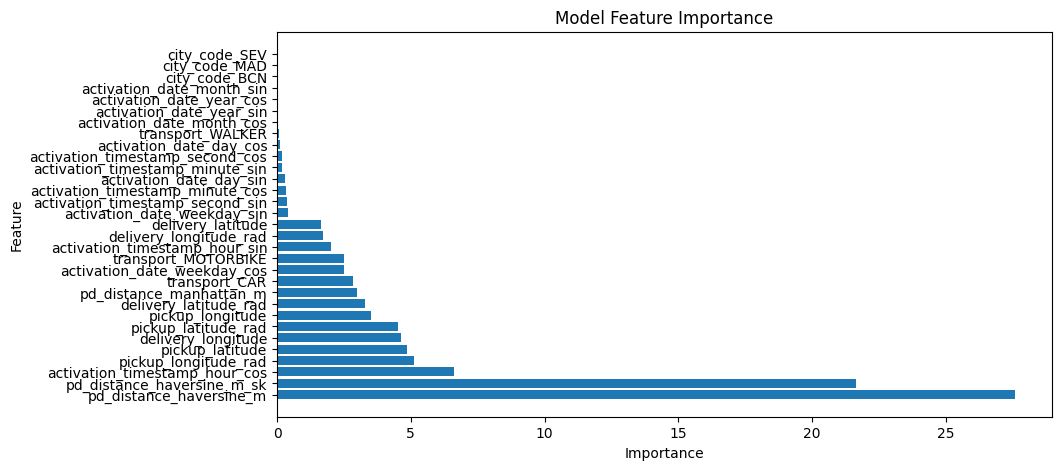

In [115]:
model_catboost_cyclical.plot_feature_importance(X_test)

In [116]:
y_test_0 = y_test.loc[0]
y_test_0_pred = model_catboost_cyclical.predict(X_test.iloc[[0]]).item()
print(f"True delivery time: {y_test_0}")
print(f"Predicted delivery time: {y_test_0_pred}")
print(f"Diff: {y_test_0_pred - y_test_0}")

True delivery time: 319.677
Predicted delivery time: 470.9375015663103
Diff: 151.26050156631027


In [117]:
results_dataset = model_catboost_cyclical.test(data_test, y_test)
results_dataset.head(20)

,country_code,order_id,courier_id,creation_timestamp,activation_timestamp,transport,pickup_latitude,pickup_longitude,delivery_latitude,delivery_longitude,...,delivery_latitude_rad,delivery_longitude_rad,pd_distance_haversine_m,pd_distance_haversine_m_sk,pd_distance_manhattan_m,creation_date,city_code,target,prediction,residual
0,ES,100933187613,176241347,2024-10-14 23:24:53+00:00,2024-10-14 23:24:54+00:00,BICYCLE,38.35,-0.48,38.35,-0.49,...,0.67,-0.01,636.15,636.15,893.84,2024-10-14,ALC,319.68,470.94,151.26
1,ES,100933198445,10191824,2024-10-14 23:37:45+00:00,2024-10-14 23:37:46+00:00,MOTORBIKE,38.35,-0.48,38.34,-0.49,...,0.67,-0.01,774.11,774.11,1012.03,2024-10-14,ALC,811.65,415.18,-396.47
2,ES,100931749423,169099229,2024-10-14 12:57:37+00:00,2024-10-14 12:57:38+00:00,CAR,38.36,-0.49,38.34,-0.49,...,0.67,-0.01,2205.90,2205.90,2337.58,2024-10-14,ALC,614.70,714.43,99.73
3,ES,100931867858,177428955,2024-10-14 13:44:05+00:00,2024-10-14 13:44:06+00:00,BICYCLE,38.35,-0.47,38.34,-0.50,...,0.67,-0.01,2628.16,2628.16,3677.11,2024-10-14,ALC,1111.15,958.98,-152.17
4,ES,100931917343,3548605,2024-10-14 14:03:19+00:00,2024-10-14 14:03:20+00:00,CAR,38.35,-0.49,38.35,-0.49,...,0.67,-0.01,681.33,681.33,941.43,2024-10-14,ALC,806.57,460.71,-345.86
5,ES,100931951627,173230053,2024-10-14 14:16:28+00:00,2024-10-14 14:16:29+00:00,MOTORBIKE,38.36,-0.50,38.37,-0.43,...,0.67,-0.01,6103.51,6103.51,6660.54,2024-10-14,ALC,1105.37,1159.54,54.17
6,ES,100932201108,141248791,2024-10-14 16:08:33+00:00,2024-10-14 16:08:35+00:00,MOTORBIKE,38.37,-0.51,38.38,-0.50,...,0.67,-0.01,819.69,819.69,1097.23,2024-10-14,ALC,290.56,470.77,180.21
7,ES,100932473558,39980765,2024-10-14 18:16:45+00:00,2024-10-14 18:16:45+00:00,CAR,38.35,-0.48,38.35,-0.52,...,0.67,-0.01,2808.36,2808.36,2975.41,2024-10-14,ALC,754.79,884.37,129.58
8,ES,100932857877,177428955,2024-10-14 20:36:33+00:00,2024-10-14 20:36:34+00:00,BICYCLE,38.35,-0.47,38.34,-0.48,...,0.67,-0.01,1575.89,1575.89,2230.19,2024-10-14,ALC,1476.80,762.72,-714.08
9,ES,100932926010,171303156,2024-10-14 21:00:04+00:00,2024-10-14 21:00:05+00:00,MOTORBIKE,38.37,-0.41,38.39,-0.41,...,0.67,-0.01,2062.63,2062.63,2099.82,2024-10-14,ALC,622.03,523.95,-98.08


In [118]:
model_catboost_cyclical_eval = model_catboost_cyclical.evaluate(X_test, y_test)
print(f"CatBoost Model (Cyclical) Evaluation: MAE: {model_catboost_cyclical_eval[0]}, MSE: {model_catboost_cyclical_eval[1]}, R2: {model_catboost_cyclical_eval[2]}")

CatBoost Model (Cyclical) Evaluation: MAE: 165.95008611822738, MSE: 106643.15955800201, R2: 0.32633753266625165


## Models comparison

In [119]:
models = ['model_bl_sum' , 'model_bl_mean', 'model_linear_3d', 'model_linear_7d', 'model_linear', 'model_linear_cyclical',
          'model_linear_minmaxscaler', 'model_linear_stdscaler', 'model_linear_SGD_stdscaler', 'model_decision_tree',
          'model_decision_tree_cyclical', 'model_random_forest', 'model_random_forest_cyclical', 'model_gradient_boosting',
          'model_gradient_boosting_cyclical', 'model_hist_gradient_boosting', 'model_hist_gradient_boosting_cyclical',
          'model_xgboost_cyclical', 'model_lightgbm_cyclical', 'model_catboost_cyclical']

data = []
for model in models:
    time_value = eval(model + '_time')
    eval_value = eval(model + '_eval')
    data.append([model, time_value, eval_value[0], eval_value[1], eval_value[2]])

models_eval = pd.DataFrame(data, columns=['Model', 'Training time', 'MAE', 'MSE', 'R2'])
models_eval['Training time'] = models_eval['Training time'].apply(
    lambda x: (datetime.datetime.min + x).strftime('%H:%M:%S.%f')
)
models_eval

,Model,Training time,MAE,MSE,R2
0,model_bl_sum,00:00:00.358273,256.39,179628.88,-0.13
1,model_bl_mean,00:00:00.290445,239.81,157993.40,0.00
2,model_linear_3d,00:00:00.334595,903086.68,818405053516.16,-5594016.79
3,model_linear_7d,00:00:00.668742,388.28,289625.07,-0.98
4,model_linear,00:00:01.189495,182.03,114931.62,0.27
5,model_linear_cyclical,00:00:02.464113,181.45,114092.69,0.28
6,model_linear_minmaxscaler,00:00:01.893314,182.03,114930.38,0.27
7,model_linear_stdscaler,00:00:01.945393,182.04,114931.18,0.27
8,model_linear_SGD_stdscaler,00:00:08.995919,181.23,115497.14,0.27
9,model_decision_tree,00:00:23.136207,255.27,226992.58,-0.43
